In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import os
import sys
from collections import defaultdict
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt

In [2]:
def tpr_weight_funtion(y_true,y_predict):
    d = pd.DataFrame()
    d['prob'] = list(y_predict)
    d['y'] = list(y_true)
    d = d.sort_values(['prob'], ascending=[0])
    y = d.y
    PosAll = pd.Series(y).value_counts()[1]
    NegAll = pd.Series(y).value_counts()[0]
    pCumsum = d['y'].cumsum()
    nCumsum = np.arange(len(y)) - pCumsum + 1
    pCumsumPer = pCumsum / PosAll
    nCumsumPer = nCumsum / NegAll
    TR1 = pCumsumPer[abs(nCumsumPer-0.001).idxmin()]
    TR2 = pCumsumPer[abs(nCumsumPer-0.005).idxmin()]
    TR3 = pCumsumPer[abs(nCumsumPer-0.01).idxmin()]
    return 'TC_AUC',0.4 * TR1 + 0.3 * TR2 + 0.3 * TR3,True

In [3]:
def generate_test_sub():
    if not os.path.exists("../input/sub.csv"):
        operation_UID = op_test['UID'].values.tolist()
        transaction_UID = trans_test['UID'].values.tolist()
        test_ids = list(set(operation_UID).union(set(transaction_UID)))
        pd.DataFrame({"UID":test_ids}).to_csv("../input/sub.csv",index=False)
        return pd.DataFrame({"UID":test_ids})
    else:
        return pd.read_csv("../input/sub.csv")

In [4]:
def process_day_seq(seq):
    if len(seq)<2:
        return np.nan
    seq.sort()
    gap = []
    for i in range(len(seq)-1):
        gap.append(seq[i+1]-seq[i])
    return np.array(gap)

In [5]:
def get_baseline_feature(op,trans,label):
    for feature in op.columns[2:]:
        label = label.merge(op.groupby(['UID'])[feature].count().reset_index(),on='UID',how='left')
        label =label.merge(op.groupby(['UID'])[feature].nunique().reset_index(),on='UID',how='left')
    
    for feature in trans.columns[2:]:
        if trans_train[feature].dtype == 'object':
            label =label.merge(trans.groupby(['UID'])[feature].count().reset_index(),on='UID',how='left')
            label =label.merge(trans.groupby(['UID'])[feature].nunique().reset_index(),on='UID',how='left')
        else:
            label =label.merge(trans.groupby(['UID'])[feature].count().reset_index(),on='UID',how='left')
            label =label.merge(trans.groupby(['UID'])[feature].nunique().reset_index(),on='UID',how='left')
            label =label.merge(trans.groupby(['UID'])[feature].max().reset_index(),on='UID',how='left')
            label =label.merge(trans.groupby(['UID'])[feature].min().reset_index(),on='UID',how='left')
            label =label.merge(trans.groupby(['UID'])[feature].sum().reset_index(),on='UID',how='left')
            label =label.merge(trans.groupby(['UID'])[feature].mean().reset_index(),on='UID',how='left')
            label =label.merge(trans.groupby(['UID'])[feature].std().reset_index(),on='UID',how='left')
    return label

In [6]:
def get_modified_feature(op,trans,label):
    op_group = op.groupby(['UID'])
    trans_group = trans.groupby(['UID'])
    for feature in op.columns[1:]:
        op_group_f = op_group[feature]
        label = label.merge(op_group_f.count().reset_index().rename(columns={feature:(feature+'_count')}),on='UID',how='left')
        label =label.merge(op_group_f.nunique().reset_index().rename(columns={feature:(feature+'_nunique')}),on='UID',how='left')
        if feature == 'time':
            label =label.merge(op_group_f.max().reset_index().rename(columns={feature:(feature+'_max')}),on='UID',how='left')
            label =label.merge(op_group_f.min().reset_index().rename(columns={feature:(feature+'_min')}),on='UID',how='left')
            label =label.merge(op_group_f.sum().reset_index().rename(columns={feature:(feature+'_sum')}),on='UID',how='left')
            label =label.merge(op_group_f.mean().reset_index().rename(columns={feature:(feature+'_mean')}),on='UID',how='left')
            label =label.merge(op_group_f.std().reset_index().rename(columns={feature:(feature+'_std')}),on='UID',how='left')
        if feature == 'day':
            tmp = op_group_f.unique().reset_index()
            tmp['day'] = tmp['day'].map(lambda x:process_day_seq(x))
            tmp['max_gap'] = tmp['day'].map(lambda x:np.max(x))
            tmp['min_gap'] = tmp['day'].map(lambda x:np.min(x))
            tmp['mean_gap'] = tmp['day'].map(lambda x:np.mean(x))
            tmp['std_gap'] = tmp['day'].map(lambda x:np.std(x))
            tmp = tmp.drop(['day'], axis=1)
            label = label.merge(tmp, on='UID',how='left')
            tmp2 = op_group_f.value_counts().rename('day_cnt').reset_index().groupby(['UID'])['day_cnt']
            label = label.merge(tmp2.max().reset_index().rename(columns={'day_cnt':'day_cnt_max'}), on='UID',how='left')
            label = label.merge(tmp2.min().reset_index().rename(columns={'day_cnt':'day_cnt_min'}), on='UID',how='left')
            label = label.merge(tmp2.mean().reset_index().rename(columns={'day_cnt':'day_cnt_mean'}), on='UID',how='left')
            label = label.merge(tmp2.std().reset_index().rename(columns={'day_cnt':'day_cnt_std'}), on='UID',how='left')
    for feature in trans.columns[1:]:
        trans_group_f = trans_group[feature]
        if trans[feature].dtype == 'object':
            label =label.merge(trans_group_f.count().reset_index().rename(columns={feature:(feature+'_count')}),on='UID',how='left')
            label =label.merge(trans_group_f.nunique().reset_index().rename(columns={feature:(feature+'_nunique')}),on='UID',how='left')
        else:
            label =label.merge(trans_group_f.count().reset_index().rename(columns={feature:(feature+'_count')}),on='UID',how='left')
            label =label.merge(trans_group_f.nunique().reset_index().rename(columns={feature:(feature+'_nunique')}),on='UID',how='left')
            label =label.merge(trans_group_f.max().reset_index().rename(columns={feature:(feature+'_max')}),on='UID',how='left')
            label =label.merge(trans_group_f.min().reset_index().rename(columns={feature:(feature+'_min')}),on='UID',how='left')
            label =label.merge(trans_group_f.sum().reset_index().rename(columns={feature:(feature+'_sum')}),on='UID',how='left')
            label =label.merge(trans_group_f.mean().reset_index().rename(columns={feature:(feature+'_mean')}),on='UID',how='left')
            label =label.merge(trans_group_f.std().reset_index().rename(columns={feature:(feature+'_std')}),on='UID',how='left')
            if feature == 'day':
                tmp = trans_group_f.unique().reset_index()
                tmp['day'] = tmp['day'].map(lambda x:process_day_seq(x))
                tmp['T_max_gap'] = tmp['day'].map(lambda x:np.max(x))
                tmp['T_min_gap'] = tmp['day'].map(lambda x:np.min(x))
                tmp['T_mean_gap'] = tmp['day'].map(lambda x:np.mean(x))
                tmp['T_std_gap'] = tmp['day'].map(lambda x:np.std(x))
                tmp = tmp.drop(['day'], axis=1)
                label = label.merge(tmp, on='UID',how='left')
                tmp2 = trans_group_f.value_counts().rename('day_cnt').reset_index().groupby(['UID'])['day_cnt']
                label = label.merge(tmp2.max().reset_index().rename(columns={'day_cnt':'T_day_cnt_max'}), on='UID',how='left')
                label = label.merge(tmp2.min().reset_index().rename(columns={'day_cnt':'T_day_cnt_min'}), on='UID',how='left')
                label = label.merge(tmp2.mean().reset_index().rename(columns={'day_cnt':'T_day_cnt_mean'}), on='UID',how='left')
                label = label.merge(tmp2.std().reset_index().rename(columns={'day_cnt':'T_day_cnt_std'}), on='UID',how='left')
    return label

In [7]:
def workday_day_cnt(seq, weekends):
    return len(seq)-len(set(seq) & set(weekends))
def weekend_day_cnt(seq,weekends):
    return len(set(seq) & set(weekends))

In [8]:
def get_time_window_feature(op, trans, label, is_train):
    if is_train:
        weekends = [1,2,8,9,15,16,22,23,29,30]
    else:
        weekends = [6,7,13,14,20,21,27,28]
    op_group = op.groupby('UID')
    trans_group = trans.groupby('UID')
    #OP
    op_group_f = op_group['day']
    tmp = op_group_f.unique().reset_index()
    tmp['workday_cnt'] = tmp['day'].map(lambda x:workday_day_cnt(x,weekends)) 
    tmp['weekend_day_cnt'] = tmp['day'].map(lambda x:weekend_day_cnt(x,weekends))
    tmp = tmp.drop(['day'], axis=1)
    label = label.merge(tmp, on='UID',how='left')
    
    op_workday = op[~(op['day'].isin(weekends))]    
    tmp2 = op_workday.groupby('UID')['day'].value_counts().rename('day_cnt').reset_index().groupby(['UID'])['day_cnt']
    label = label.merge(tmp2.max().reset_index().rename(columns={'day_cnt':'workday_day_cnt_max'}), on='UID',how='left')
    label = label.merge(tmp2.min().reset_index().rename(columns={'day_cnt':'workday_day_cnt_min'}), on='UID',how='left')
    label = label.merge(tmp2.mean().reset_index().rename(columns={'day_cnt':'workday_day_cnt_mean'}), on='UID',how='left')
    label = label.merge(tmp2.std().reset_index().rename(columns={'day_cnt':'workday_day_cnt_std'}), on='UID',how='left')
    
    op_weekend = op[op['day'].isin(weekends)]    
    tmp2 = op_weekend.groupby('UID')['day'].value_counts().rename('day_cnt').reset_index().groupby(['UID'])['day_cnt']
    label = label.merge(tmp2.max().reset_index().rename(columns={'day_cnt':'weekend_day_cnt_max'}), on='UID',how='left')
    label = label.merge(tmp2.min().reset_index().rename(columns={'day_cnt':'weekend_day_cnt_min'}), on='UID',how='left')
    label = label.merge(tmp2.mean().reset_index().rename(columns={'day_cnt':'weekend_day_cnt_mean'}), on='UID',how='left')
    label = label.merge(tmp2.std().reset_index().rename(columns={'day_cnt':'weekend_day_cnt_std'}), on='UID',how='left')
    
    #TRANS
    trans_group_f = trans_group['day']
    tmp = trans_group_f.unique().reset_index()
    tmp['workday_cnt'] = tmp['day'].map(lambda x:workday_day_cnt(x,weekends)) 
    tmp['weekend_day_cnt'] = tmp['day'].map(lambda x:weekend_day_cnt(x,weekends))
    tmp = tmp.drop(['day'], axis=1)
    label = label.merge(tmp, on='UID',how='left')
    
    trans_workday = trans[~(trans['day'].isin(weekends))]    
    tmp2 = trans_workday.groupby('UID')['day'].value_counts().rename('day_cnt').reset_index().groupby(['UID'])['day_cnt']
    label = label.merge(tmp2.max().reset_index().rename(columns={'day_cnt':'workday_day_cnt_max'}), on='UID',how='left')
    label = label.merge(tmp2.min().reset_index().rename(columns={'day_cnt':'workday_day_cnt_min'}), on='UID',how='left')
    label = label.merge(tmp2.mean().reset_index().rename(columns={'day_cnt':'workday_day_cnt_mean'}), on='UID',how='left')
    label = label.merge(tmp2.std().reset_index().rename(columns={'day_cnt':'workday_day_cnt_std'}), on='UID',how='left')
    
    trans_weekend = trans[trans['day'].isin(weekends)]
    tmp2 = trans_weekend.groupby('UID')['day'].value_counts().rename('day_cnt').reset_index().groupby(['UID'])['day_cnt']
    label = label.merge(tmp2.max().reset_index().rename(columns={'day_cnt':'weekend_day_cnt_max'}), on='UID',how='left')
    label = label.merge(tmp2.min().reset_index().rename(columns={'day_cnt':'weekend_day_cnt_min'}), on='UID',how='left')
    label = label.merge(tmp2.mean().reset_index().rename(columns={'day_cnt':'weekend_day_cnt_mean'}), on='UID',how='left')
    label = label.merge(tmp2.std().reset_index().rename(columns={'day_cnt':'weekend_day_cnt_std'}), on='UID',how='left')
    
    return label

In [39]:
def get_day_feature(op, trans, label):
    print('OP begin...')
    f_u_dic = defaultdict(lambda: defaultdict(int))#dict[feature][u] = value
    for u, subdf in op.groupby('UID'):
        f_dic = defaultdict(list)#[feature] = list
        for day, subdf2 in subdf.groupby('day'):
            tmp = subdf2.groupby(subdf2['time'].map(lambda x:int(x)))['time'].count()
            hour_max = tmp.max()
            f_dic['dense_times'].append(hour_max)
            hour = tmp.argmax()
            n_hour = tmp.shape[0]
            f_dic['nunique_hour'].append(n_hour)
            gap = subdf2[subdf2['time'].map(lambda x:int(x))==hour]['time'].max() \
            - subdf2[subdf2['time'].map(lambda x:int(x))==hour]['time'].min()
            if gap==0:
                op_f = 0
            else:
                op_f = (hour_max-1)/gap
            f_dic['op/h'].append(op_f)
            for feature in op.columns[2:]:
                if feature == 'time':
                    continue
                f_dic[feature+'_nunique'] = subdf2[feature].nunique()
                f_dic[feature+'_nunique/t'] = subdf2[feature].nunique()/n_hour

        f_u_dic['max_day_dense_times'][u] = np.max(f_dic['dense_times'])
        f_u_dic['mean_day_dense_times'][u] = np.mean(f_dic['dense_times'])
        f_u_dic['std_day_dense_times'][u] = np.std(f_dic['dense_times'])

        f_u_dic['max_day_nunique_hour'][u] = np.max(f_dic['nunique_hour'])
        f_u_dic['mean_day_nunique_hour'][u] = np.mean(f_dic['nunique_hour'])
        f_u_dic['std_day_nunique_hour'][u] = np.std(f_dic['nunique_hour'])

        f_u_dic['max_day_op/h'][u] = np.max(f_dic['op/h'])
        f_u_dic['mean_day_op/h'][u] = np.mean(f_dic['op/h'])
        f_u_dic['std_day_op/h'][u] = np.std(f_dic['op/h'])

        for feature in op.columns[2:]:
            if feature == 'time':
                continue
            f_u_dic['max_day_'+feature+'_nunique'][u] = np.max(f_dic[feature+'_nunique'])
            f_u_dic['mean_day_'+feature+'_nunique'][u] = np.mean(f_dic[feature+'_nunique'])
            f_u_dic['std_day_'+feature+'_nunique'][u] = np.std(f_dic[feature+'_nunique'])

            f_u_dic['max_day_'+feature+'_nunique/t'][u] = np.max(f_dic[feature+'_nunique/t'])
            f_u_dic['mean_day_'+feature+'_nunique/t'][u] = np.mean(f_dic[feature+'_nunique/t'])
            f_u_dic['std_day_'+feature+'_nunique/t'][u] = np.std(f_dic[feature+'_nunique/t'])
    for feature in f_u_dic.keys():
        uuu = []
        fff = []
        for u, v in f_u_dic[feature].items():
            uuu.append(u)
            fff.append(v)
        label = label.merge(pd.DataFrame({'UID':uuu, feature:fff}), on='UID', how='left')
    
    print('TRANS begin...')
    f_u_dic = defaultdict(lambda: defaultdict(int))#dict[feature][u] = value
    for u, subdf in trans.groupby('UID'):
        f_dic = defaultdict(list)#[feature] = list
        for day, subdf2 in subdf.groupby('day'):
            tmp = subdf2.groupby(subdf2['time'].map(lambda x:int(x)))['time'].count()
            hour_max = tmp.max()
            f_dic['dense_times'].append(hour_max)
            hour = tmp.argmax()
            n_hour = tmp.shape[0]
            f_dic['nunique_hour'].append(n_hour)
            gap = subdf2[subdf2['time'].map(lambda x:int(x))==hour]['time'].max() \
            - subdf2[subdf2['time'].map(lambda x:int(x))==hour]['time'].min()
            if gap==0:
                trans_f = 0
            else:
                trans_f = (hour_max-1)/gap
            f_dic['trans/h'].append(trans_f)
            
            f_dic['mean_day_trans_amt'].append(subdf2['trans_amt'].mean())
            
            for feature in trans.columns[1:]:
                if feature in ['time', 'day']:
                    continue
                f_dic[feature+'_nunique'] = subdf2[feature].nunique()
                f_dic[feature+'_nunique/t'] = subdf2[feature].nunique()/n_hour

        f_u_dic['max_day_dense_times'][u] = np.max(f_dic['dense_times'])
        f_u_dic['mean_day_dense_times'][u] = np.mean(f_dic['dense_times'])
        f_u_dic['std_day_dense_times'][u] = np.std(f_dic['dense_times'])

        f_u_dic['max_day_nunique_hour'][u] = np.max(f_dic['nunique_hour'])
        f_u_dic['mean_day_nunique_hour'][u] = np.mean(f_dic['nunique_hour'])
        f_u_dic['std_day_nunique_hour'][u] = np.std(f_dic['nunique_hour'])

        f_u_dic['max_day_trans/h'][u] = np.max(f_dic['trans/h'])
        f_u_dic['mean_day_trans/h'][u] = np.mean(f_dic['trans/h'])
        f_u_dic['std_day_trans/h'][u] = np.std(f_dic['trans/h'])
        
        freq_amt = subdf.groupby('trans_amt')['trans_amt'].count().argmax()
        f_u_dic['most_freq_trans_amt'][u] = freq_amt
        f_u_dic['trans_amt_102_cnt'][u] = subdf[subdf['trans_amt']==102].shape[0]
        f_u_dic['trans_amt_2818_cnt'][u] = subdf[subdf['trans_amt']==2818].shape[0]
        f_u_dic['trans_amt_1459_cnt'][u] = subdf[subdf['trans_amt']==1459].shape[0]
        
        for feature in trans.columns[1:]:
            if feature in ['time', 'day']:
                continue
            f_u_dic['max_day_'+feature+'_nunique'][u] = np.max(f_dic[feature+'_nunique'])
            f_u_dic['mean_day_'+feature+'_nunique'][u] = np.mean(f_dic[feature+'_nunique'])
            f_u_dic['std_day_'+feature+'_nunique'][u] = np.std(f_dic[feature+'_nunique'])

            f_u_dic['max_day_'+feature+'_nunique/t'][u] = np.max(f_dic[feature+'_nunique/t'])
            f_u_dic['mean_day_'+feature+'_nunique/t'][u] = np.mean(f_dic[feature+'_nunique/t'])
            f_u_dic['std_day_'+feature+'_nunique/t'][u] = np.std(f_dic[feature+'_nunique/t'])
    for feature in f_u_dic.keys():
        uuu = []
        fff = []
        for u, v in f_u_dic[feature].items():
            uuu.append(u)
            fff.append(v)
        label = label.merge(pd.DataFrame({'UID':uuu, ('T_'+feature):fff}), on='UID', how='left')
    return label

In [40]:
day_train = get_day_feature(op_train, trans_train, y)

OP begin...
TRANS begin...


In [41]:
day_train.head()

,UID,Tag,max_day_dense_times,mean_day_dense_times,std_day_dense_times,max_day_nunique_hour,mean_day_nunique_hour,std_day_nunique_hour,max_day_op/h,mean_day_op/h,std_day_op/h,max_day_mode_nunique,mean_daymode_nunique,std_daymode_nunique,max_day_mode_nunique/t,mean_daymode_nunique/t,std_daymode_nunique/t,max_day_success_nunique,mean_daysuccess_nunique,std_daysuccess_nunique,max_day_success_nunique/t,mean_daysuccess_nunique/t,std_daysuccess_nunique/t,max_day_os_nunique,mean_dayos_nunique,std_dayos_nunique,max_day_os_nunique/t,mean_dayos_nunique/t,std_dayos_nunique/t,max_day_version_nunique,mean_dayversion_nunique,std_dayversion_nunique,max_day_version_nunique/t,mean_dayversion_nunique/t,std_dayversion_nunique/t,max_day_device1_nunique,mean_daydevice1_nunique,std_daydevice1_nunique,max_day_device1_nunique/t,mean_daydevice1_nunique/t,std_daydevice1_nunique/t,max_day_device2_nunique,mean_daydevice2_nunique,std_daydevice2_nunique,max_day_device2_nunique/t,mean_daydevice2_nunique/t,std_daydevice2_nunique/t,max_day_device_code1_nunique,mean_daydevice_code1_nunique,std_daydevice_code1_nunique,max_day_device_code1_nunique/t,mean_daydevice_code1_nunique/t,std_daydevice_code1_nunique/t,max_day_device_code2_nunique,mean_daydevice_code2_nunique,std_daydevice_code2_nunique,max_day_device_code2_nunique/t,mean_daydevice_code2_nunique/t,std_daydevice_code2_nunique/t,max_day_device_code3_nunique,mean_daydevice_code3_nunique,std_daydevice_code3_nunique,max_day_device_code3_nunique/t,mean_daydevice_code3_nunique/t,std_daydevice_code3_nunique/t,max_day_mac1_nunique,mean_daymac1_nunique,std_daymac1_nunique,max_day_mac1_nunique/t,mean_daymac1_nunique/t,std_daymac1_nunique/t,max_day_mac2_nunique,mean_daymac2_nunique,std_daymac2_nunique,max_day_mac2_nunique/t,mean_daymac2_nunique/t,std_daymac2_nunique/t,max_day_ip1_nunique,mean_dayip1_nunique,std_dayip1_nunique,max_day_ip1_nunique/t,mean_dayip1_nunique/t,std_dayip1_nunique/t,max_day_ip2_nunique,mean_dayip2_nunique,std_dayip2_nunique,max_day_ip2_nunique/t,mean_dayip2_nunique/t,std_dayip2_nunique/t,max_day_wifi_nunique,mean_daywifi_nunique,std_daywifi_nunique,max_day_wifi_nunique/t,mean_daywifi_nunique/t,std_daywifi_nunique/t,max_day_geo_code_nunique,mean_daygeo_code_nunique,std_daygeo_code_nunique,max_day_geo_code_nunique/t,mean_daygeo_code_nunique/t,std_daygeo_code_nunique/t,max_day_ip1_sub_nunique,mean_dayip1_sub_nunique,std_dayip1_sub_nunique,max_day_ip1_sub_nunique/t,mean_dayip1_sub_nunique/t,std_dayip1_sub_nunique/t,max_day_ip2_sub_nunique,mean_dayip2_sub_nunique,std_dayip2_sub_nunique,max_day_ip2_sub_nunique/t,mean_dayip2_sub_nunique/t,std_dayip2_sub_nunique/t,T_max_day_dense_times,T_mean_day_dense_times,T_std_day_dense_times,T_max_day_nunique_hour,T_mean_day_nunique_hour,T_std_day_nunique_hour,T_max_day_trans/h,T_mean_day_trans/h,T_std_day_trans/h,T_most_freq_trans_amt,T_trans_amt_102_cnt,T_trans_amt_2818_cnt,T_trans_amt_1459_cnt,T_max_day_channel_nunique,T_mean_daychannel_nunique,T_std_daychannel_nunique,T_max_day_channel_nunique/t,T_mean_daychannel_nunique/t,T_std_daychannel_nunique/t,T_max_day_trans_amt_nunique,T_mean_daytrans_amt_nunique,T_std_daytrans_amt_nunique,T_max_day_trans_amt_nunique/t,T_mean_daytrans_amt_nunique/t,T_std_daytrans_amt_nunique/t,T_max_day_amt_src1_nunique,T_mean_dayamt_src1_nunique,T_std_dayamt_src1_nunique,T_max_day_amt_src1_nunique/t,T_mean_dayamt_src1_nunique/t,T_std_dayamt_src1_nunique/t,T_max_day_merchant_nunique,T_mean_daymerchant_nunique,T_std_daymerchant_nunique,T_max_day_merchant_nunique/t,T_mean_daymerchant_nunique/t,T_std_daymerchant_nunique/t,T_max_day_code1_nunique,T_mean_daycode1_nunique,T_std_daycode1_nunique,T_max_day_code1_nunique/t,T_mean_daycode1_nunique/t,T_std_daycode1_nunique/t,T_max_day_code2_nunique,T_mean_daycode2_nunique,T_std_daycode2_nunique,T_max_day_code2_nunique/t,T_mean_daycode2_nunique/t,T_std_daycode2_nunique/t,T_max_day_trans_type1_nunique,T_mean_daytrans_type1_nunique,T_std_daytrans_type1_nunique,T_max_day_trans_type1_nunique/t,T_mean_

In [42]:
day_test = get_day_feature(op_test, trans_test, sub)

OP begin...
TRANS begin...


In [44]:
day_train = day_train.drop(['Tag'], axis=1)
day_test = day_test.drop(['Tag'], axis=1)

ValueError: labels ['Tag'] not contained in axis

In [59]:
# def get_modified_feature(op,trans,label):
#     op_group = op.groupby(['UID'])
#     trans_group = trans.groupby(['UID'])
#     for feature in op.columns[1:]:
#         op_group_f = op_group[feature]
#         label = label.merge(op_group_f.count().reset_index().rename(columns={feature:(feature+'_count')}),on='UID',how='left')#Non NAN
#         label = label.merge(op_group_f.nunique().reset_index().rename(columns={feature:(feature+'_nunique')}),on='UID',how='left')
#         if feature == 'time':
#             label =label.merge(op_group_f.max().reset_index().rename(columns={feature:(feature+'_max')}),on='UID',how='left')
#             label =label.merge(op_group_f.min().reset_index().rename(columns={feature:(feature+'_min')}),on='UID',how='left')
#             label =label.merge(op_group_f.sum().reset_index().rename(columns={feature:(feature+'_sum')}),on='UID',how='left')
#             label =label.merge(op_group_f.mean().reset_index().rename(columns={feature:(feature+'_mean')}),on='UID',how='left')
#             label =label.merge(op_group_f.std().reset_index().rename(columns={feature:(feature+'_std')}),on='UID',how='left')
#         if feature == 'day':
#             tmp = op_group_f.unique().reset_index()
#             tmp['day'] = tmp['day'].map(lambda x:process_day_seq(x))
#             tmp['max_gap'] = tmp['day'].map(lambda x:np.max(x))
#             tmp['min_gap'] = tmp['day'].map(lambda x:np.min(x))
#             tmp['mean_gap'] = tmp['day'].map(lambda x:np.mean(x))
#             tmp['std_gap'] = tmp['day'].map(lambda x:np.std(x))
#             tmp = tmp.drop(['day'], axis=1)
#             label = label.merge(tmp, on='UID',how='left')
#             tmp2 = op_group_f.value_counts().rename('day_cnt').reset_index().groupby(['UID'])['day_cnt']
#             label = label.merge(tmp2.max().reset_index().rename(columns={'day_cnt':'day_cnt_max'}), on='UID',how='left')
#             label = label.merge(tmp2.min().reset_index().rename(columns={'day_cnt':'day_cnt_min'}), on='UID',how='left')
#             label = label.merge(tmp2.mean().reset_index().rename(columns={'day_cnt':'day_cnt_mean'}), on='UID',how='left')
#             label = label.merge(tmp2.std().reset_index().rename(columns={'day_cnt':'day_cnt_std'}), on='UID',how='left')
#     for feature in trans.columns[1:]:
#         trans_group_f = trans_group[feature]
#         label =label.merge(trans_group_f.count().reset_index().rename(columns={feature:(feature+'_count')}),on='UID',how='left')
#         label =label.merge(trans_group_f.nunique().reset_index().rename(columns={feature:(feature+'_nunique')}),on='UID',how='left')
#         if feature in ['trans_amt', 'bal', 'time']:
#             label =label.merge(trans_group_f.max().reset_index().rename(columns={feature:(feature+'_max')}),on='UID',how='left')
#             label =label.merge(trans_group_f.min().reset_index().rename(columns={feature:(feature+'_min')}),on='UID',how='left')
#             label =label.merge(trans_group_f.sum().reset_index().rename(columns={feature:(feature+'_sum')}),on='UID',how='left')
#             label =label.merge(trans_group_f.mean().reset_index().rename(columns={feature:(feature+'_mean')}),on='UID',how='left')
#             label =label.merge(trans_group_f.std().reset_index().rename(columns={feature:(feature+'_std')}),on='UID',how='left')
#         if feature == 'day':
#             tmp = trans_group_f.unique().reset_index()
#             tmp['day'] = tmp['day'].map(lambda x:process_day_seq(x))
#             tmp['T_max_gap'] = tmp['day'].map(lambda x:np.max(x))
#             tmp['T_min_gap'] = tmp['day'].map(lambda x:np.min(x))
#             tmp['T_mean_gap'] = tmp['day'].map(lambda x:np.mean(x))
#             tmp['T_std_gap'] = tmp['day'].map(lambda x:np.std(x))
#             tmp = tmp.drop(['day'], axis=1)
#             label = label.merge(tmp, on='UID',how='left')
#             tmp2 = trans_group_f.value_counts().rename('day_cnt').reset_index().groupby(['UID'])['day_cnt']
#             label = label.merge(tmp2.max().reset_index().rename(columns={'day_cnt':'T_day_cnt_max'}), on='UID',how='left')
#             label = label.merge(tmp2.min().reset_index().rename(columns={'day_cnt':'T_day_cnt_min'}), on='UID',how='left')
#             label = label.merge(tmp2.mean().reset_index().rename(columns={'day_cnt':'T_day_cnt_mean'}), on='UID',how='left')
#             label = label.merge(tmp2.std().reset_index().rename(columns={'day_cnt':'T_day_cnt_std'}), on='UID',how='left')
#     return label

# Load the data

In [10]:
pd.options.display.max_columns = None

In [11]:
op_train = pd.read_csv('../input/operation_train_new.csv')
trans_train = pd.read_csv('../input/transaction_train_new.csv')

op_test = pd.read_csv('../input/operation_round1_new.csv')
trans_test = pd.read_csv('../input/transaction_round1_new.csv')

y = pd.read_csv('../input/tag_train_new.csv')

/home/xdd/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Preprocess

### Time

In [12]:
op_train['time'] = op_train['time'].map(lambda x:int(x[:2])+int(x[3:5])/60+int(x[6:8])/3600)
trans_train['time'] = trans_train['time'].map(lambda x:int(x[:2])+int(x[3:5])/60+int(x[6:8])/3600)
op_test['time'] = op_test['time'].map(lambda x:int(x[:2])+int(x[3:5])/60+int(x[6:8])/3600)
trans_test['time'] = trans_test['time'].map(lambda x:int(x[:2])+int(x[3:5])/60+int(x[6:8])/3600)

In [9]:
op_train['time'] = op_train['time'].map(lambda x:int(x[:2]))
trans_train['time'] = trans_train['time'].map(lambda x:int(x[:2]))
op_test['time'] = op_test['time'].map(lambda x:int(x[:2]))
trans_test['time'] = trans_test['time'].map(lambda x:int(x[:2]))

### STR

In [13]:
trans_train[['code1','code2']] = trans_train[['code1','code2']].fillna('')
trans_test[['code1','code2']] = trans_test[['code1','code2']].fillna('')

trans_train['code1'] = trans_train['merchant']+trans_train['code1']
trans_train['code2'] = trans_train['merchant']+trans_train['code2']

trans_test['code1'] = trans_test['merchant']+trans_test['code1']
trans_test['code2'] = trans_test['merchant']+trans_test['code2']

In [ ]:
op_train[['version', 'device1', 'device2',
          'device_code1', 'device_code2', 'device_code3',
         'mac1', 'mac2', 'ip1', 'ip2', 'wifi', 'geo_code', 'ip1_sub', 'ip2_sub'
         ]]
= op_train[['version', 'device1', 'device2',
          'device_code1', 'device_code2', 'device_code3',
         'mac1', 'mac2', 'ip1', 'ip2', 'wifi', 'geo_code', 'ip1_sub', 'ip2_sub'
         ]].fillna('UNK')
op_test[['version', 'device1', 'device2',
          'device_code1', 'device_code2', 'device_code3',
         'mac1', 'mac2', 'ip1', 'ip2', 'wifi', 'geo_code', 'ip1_sub', 'ip2_sub'
         ]]
= op_test[['version', 'device1', 'device2',
          'device_code1', 'device_code2', 'device_code3',
         'mac1', 'mac2', 'ip1', 'ip2', 'wifi', 'geo_code', 'ip1_sub', 'ip2_sub'
         ]].fillna('UNK')

trans_train[['acc_id1','device1', 'device2',
          'device_code1', 'device_code2', 'device_code3',
             'mac1', 'ip1'
            ]] 
= trans_train[['code1','code2']].fillna('')
trans_test[['code1','code2']] = trans_test[['code1','code2']].fillna('')

### Digit

In [ ]:
op_train[['success']] = op_train[['success']].fillna(-1)

### Simple

In [14]:
op_train = op_train.fillna(-1)
op_test = op_test.fillna(-1)
trans_train = trans_train.fillna(-1)
trans_test = trans_test.fillna(-1)

### Merge

In [15]:
op_train_with_label = pd.merge(op_train,y,on='UID',how='left')

In [16]:
trans_train_with_label = pd.merge(trans_train,y,on='UID',how='left')

In [17]:
op_all = pd.concat([op_train, op_test])
trans_all = pd.concat([trans_train, trans_test])

# Data Overview

In [53]:
op_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460843 entries, 0 to 1460842
Data columns (total 20 columns):
UID             1460843 non-null int64
day             1460843 non-null int64
mode            1460843 non-null object
success         1359763 non-null float64
time            1460843 non-null object
os              1460843 non-null int64
version         1208729 non-null object
device1         1209417 non-null object
device2         1032582 non-null object
device_code1    1047843 non-null object
device_code2    1015857 non-null object
device_code3    160726 non-null object
mac1            147147 non-null object
mac2            897176 non-null object
ip1             1198398 non-null object
ip2             135373 non-null object
wifi            457041 non-null object
geo_code        965455 non-null object
ip1_sub         1198398 non-null object
ip2_sub         135373 non-null object
dtypes: float64(1), int64(3), object(16)
memory usage: 222.9+ MB


In [186]:
op_test.count()

UID             1769049
day             1769049
mode            1769049
success         1676221
time            1769049
os              1769049
version         1427838
device1         1431218
device2         1268091
device_code1    1177363
device_code2    1148770
device_code3     252568
mac1             188632
mac2             992862
ip1             1415875
ip2              225083
wifi             523688
geo_code        1094992
ip1_sub         1415875
ip2_sub          225083
dtype: int64

In [169]:
trans_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264654 entries, 0 to 264653
Data columns (total 27 columns):
UID             264654 non-null int64
channel         264654 non-null int64
day             264654 non-null int64
time            264654 non-null object
trans_amt       264654 non-null int64
amt_src1        264654 non-null object
merchant        264654 non-null object
code1           24875 non-null object
code2           3219 non-null object
trans_type1     264654 non-null object
acc_id1         100318 non-null object
device_code1    174139 non-null object
device_code2    167096 non-null object
device_code3    43626 non-null object
device1         217088 non-null object
device2         225609 non-null object
mac1            173444 non-null object
ip1             225926 non-null object
bal             264654 non-null int64
amt_src2        141939 non-null object
acc_id2         28752 non-null object
acc_id3         28989 non-null object
geo_code        197194 non-null object
tra

In [172]:
trans_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168981 entries, 0 to 168980
Data columns (total 27 columns):
UID             168981 non-null int64
channel         168981 non-null int64
day             168981 non-null int64
time            168981 non-null object
trans_amt       168981 non-null int64
amt_src1        168981 non-null object
merchant        168981 non-null object
code1           12802 non-null object
code2           2382 non-null object
trans_type1     168981 non-null object
acc_id1         63195 non-null object
device_code1    106899 non-null object
device_code2    101900 non-null object
device_code3    30828 non-null object
device1         137220 non-null object
device2         139872 non-null object
mac1            106869 non-null object
ip1             136974 non-null object
bal             168981 non-null int64
amt_src2        85948 non-null object
acc_id2         18932 non-null object
acc_id3         19310 non-null object
geo_code        123490 non-null object
trans

In [170]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31179 entries, 0 to 31178
Data columns (total 2 columns):
UID    31179 non-null int64
Tag    31179 non-null int64
dtypes: int64(2)
memory usage: 487.2 KB


In [173]:
y.Tag.value_counts()

0    26894
1     4285
Name: Tag, dtype: int64

# Data with Label Distribution

# Example

In [179]:
a = op_train_with_label.groupby(['ip1_sub'])['UID'].unique()
cnt = 0
same = 0
for i in range(a.size):
    if a.iloc[i].size>1:
        cnt+=1
        crt = y[y['UID'].isin(list(a.iloc[i]))].Tag.mean()
        if crt==0 or crt==1:
            same+=1
print(a.size,cnt,same)

35290 12909 9494


# Operation overview

In [184]:
result = []
for feature in op_train_with_label.columns[1:-1]:
    if feature in ['time', 'day', 'success']:
        continue
    a = op_train_with_label.groupby([feature])['UID'].unique()
    cnt = 0
    same = 0
    same1 = 0
    for i in range(a.size):
        if a.iloc[i].size>1:
            cnt+=1
            crt = y[y['UID'].isin(list(a.iloc[i]))].Tag.mean()
            if crt==0 or crt==1:
                same+=1
                if crt==1:
                    same1+=1
    result.append((feature,a.size,cnt,same,same1))
    print(feature,a.size,cnt,same, same1)
result = pd.DataFrame(result,columns=['feature','feature_nunique','>1user_nunique','same_nunique', 'same1_nunique'])

day 30 30 0 0
mode 89 81 23 2
success 2 2 0 0
os 7 7 1 1
version 38 28 15 2
device1 2421 290 197 23
device2 1652 1041 508 45
device_code1 26184 570 472 98
device_code2 32043 530 485 100
device_code3 6285 111 97 54
mac1 11276 419 342 104
mac2 20249 613 484 133
ip1 141594 12765 10733 1038
ip2 19989 571 540 44
wifi 27712 2589 2157 94
geo_code 4056 2626 2120 10
ip1_sub 35290 12909 9494 336
ip2_sub 10449 2904 2640 55


In [203]:
for os, subdf in op_train_with_label.groupby(['mode']):
    crt = subdf.Tag.mean()
    if crt==0 or crt == 1:
        print(os,crt,subdf['UID'].unique().size)

0e72a7851fadf00b 0.0 4
12845a3fe90eb1de 0.0 7
148dc2618a3a92a4 0.0 1
1cbe3d31395984d7 0.0 1
1f287477e8f4b95a 0.0 1
290ead084a839c02 0.0 23
2ab549beba0a4482 0.0 12
30293957fcf5681c 0.0 17
44aa2d1440730479 0.0 1
4d24371c232305b3 0.0 1
6dd34621d82476a0 0.0 8
8b259df485199a2b 1.0 61
8bda7a6747b7ad7a 0.0 2
926aacd05a540d5d 0.0 8
a18c79737c17f4f9 0.0 8
a4aef803edb7874d 0.0 5
a6a93673bd79224c 0.0 3
ab37f730c615850f 0.0 33
ae18d98d880f65bc 0.0 4
be215a1560dcbf6e 0.0 11
ce2ef1dc219082d9 0.0 1
d22abe3bc961e5f2 0.0 4
d48cfe8d9921f5b6 0.0 2
da11300b15a56456 0.0 15
e00efcf34eb17f69 1.0 5
e0fc956bf4f3dfb7 0.0 1
e352f410afb1878a 0.0 1
e88d8e8ad8a93013 0.0 22
f1e83bce32405f92 0.0 43
f3bdbd82e0d55978 0.0 8
f4b0872cd482e33f 0.0 20


In [245]:
for key, subdf in op_train_with_label.groupby(['mode']):
    crt = subdf.Tag.mean()
    if crt>=0.14:
        print(key,crt,subdf['UID'].unique().size)

08017d2cb28c2348 0.14549019607843136 4005
270ca3ca8f0d1126 0.2284812978819288 1745
2e6fdb7d4ddef57f 0.19444444444444445 31
2e7e5808ff6323e8 0.9882352941176471 85
2f3e878175e34d9c 0.18284844384303112 4604
385608c64026c669 0.9083333333333333 218
79f8b86938180c3c 0.29106568811791106 9520
8b259df485199a2b 1.0 61
8c7ce5ff939e66d1 0.16500184979652238 2647
8e463287d7146285 0.2 22
963bd8a75ff9ab37 0.1616671929270603 2958
9c69742a831d6214 0.1411218292247231 2400
9faf791e291fe4a1 0.6666666666666666 3
a3f0d631c4fcaf38 0.5135135135135135 26
a698c1862f390021 0.4028960817717206 1137
ac63e881c4e19402 0.14353940037145133 3609
acfaded7e04e7ba0 0.372190983718971 11296
d25caee90b27fa9b 0.14500417176850477 27340
e00efcf34eb17f69 1.0 5


In [263]:
mean_rate = []
concat_df = []
for key, subdf in op_train_with_label.groupby(['device_code1']):
    a = subdf['UID'].unique()
    if a.size<2:
        continue
    crt = y[y['UID'].isin(list(a))].Tag.mean()
    if crt>0:
        mean_rate.append(crt)
        concat_df.append(y[y['UID'].isin(list(a))])
df = pd.concat(concat_df)
print(df.Tag.mean(), np.mean(np.array(mean_rate)))

0.7365554799183118
0.7333908697430062


In [266]:
for feature in op_train_with_label.columns[1:-1]:
    if feature in ['time', 'day', 'success']:
        continue
    mean_rate = []
    concat_df = []
    for key, subdf in op_train_with_label.groupby([feature]):
        a = subdf['UID'].unique()
        if a.size<2:
            continue
        crt = y[y['UID'].isin(list(a))].Tag.mean()
        if crt>0:
            mean_rate.append(crt)
            concat_df.append(y[y['UID'].isin(list(a))])
    df = pd.concat(concat_df)
    print(feature, df.Tag.mean(), np.mean(np.array(mean_rate)))

mode 0.12028232577665827 0.1589268117825125
os 0.15768126067380842 0.28014584944572246
version 0.13326421212856543 0.346868091999828
device1 0.17103943579955355 0.45115403556143224
device2 0.15652763867799568 0.2917305367162016
device_code1 0.7365554799183118 0.7333908697430062
device_code2 0.9304511278195489 0.8775874760501932
device_code3 0.32982171799027554 0.8688356171250691
mac1 0.20356591323880388 0.7740048836036333
mac2 0.16012876179068722 0.7413634647677454
ip1 0.6046339202965709 0.6271879154364022
ip2 0.6325088339222615 0.7768136235941114
wifi 0.3547783804002244 0.4621091989071134
geo_code 0.1757141404899868 0.25362078041217806
ip1_sub 0.21190635079523967 0.3111212753925349
ip2_sub 0.3826879271070615 0.47127154942418353


# Time analysis

# DAY

## OP

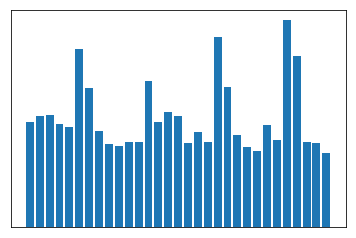

In [343]:
hhh = op_test['day'].value_counts().reset_index().sort_values(by='index')
X = np.array(hhh['index'])
Y1 = np.array(hhh['day'])
# Y2 = np.log(np.array(op1))

plt.bar(X, +Y1)
# plt.bar(X, -Y2)

# plt.xlim(1, 30)
plt.xticks(())
# plt.ylim(-1.25, 1.25)
plt.yticks(())

plt.show()

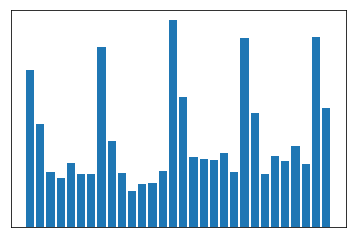

In [204]:
hhh = op_train['day'].value_counts().reset_index().sort_values(by='index')
X = np.array(hhh['index'])
Y1 = np.array(hhh['day'])
# Y2 = np.log(np.array(op1))

plt.bar(X, +Y1)
# plt.bar(X, -Y2)

# plt.xlim(1, 30)
plt.xticks(())
# plt.ylim(-1.25, 1.25)
plt.yticks(())

plt.show()

# Label Augmentation

In [133]:
op_train_with_label.head()

,UID,day,mode,success,time,os,version,device1,device2,device_code1,device_code2,device_code3,mac1,mac2,ip1,ip2,wifi,geo_code,ip1_sub,ip2_sub,Tag
0,10035,30,c8741ce15ceac2a4,1.0,17.863889,102,7.0.9,49dd36968dbfadda,OPPO R11,ecb58082e0e9b8e2,00fa2e4ba95605ef,-1,-1,a8dc52f65085212e,55dd8936655c86f6,-1,-1,wskx,e58e48fb9215116e,-1,0
1,16264,16,20a91b45ef8f8221,1.0,8.600000,200,-1,-1,-1,-1,-1,-1,-1,-1,-1,fc7fc47d6c93f554,-1,-1,-1,3502c553ea2ac187,0
2,13162,8,b668e42707ee9c7b,0.0,18.165833,102,7.0.5,630a1adff2a87007,MI MAX 2,1da225cb679a37eb,f18538156b8f9b57,-1,a8dc52f65085212e,-1,2147d925e7a8ba3c,-1,-1,-1,3591678eca3f7a23,-1,0
3,21392,23,c8741ce15ceac2a4,1.0,23.896944,102,7.0.9,630a1adff2a87007,MI 5X,d0c285513b785609,a7e79e3c2c85c8c7,-1,-1,04a2d6c090518faa,c52efc665f0af581,-1,4ff1553b1c96360e,wm4v,fdb5e20f6a6f2cd7,-1,0
4,18599,26,acfaded7e04e7ba0,1.0,11.187500,102,7.0.0,8399be6b80847240,-1,27efd832595503f6,b6457e2264266257,-1,-1,1ab9dc3eae102aa6,0fe293bea342665a,-1,-1,-1,f5009e2c6c13c80c,-1,1


In [157]:
ttt = op_train_with_label[op_train_with_label.Tag==1].copy()
ttt['version'] = ttt['version'].replace(-1, '0')
ttt['version_int'] = ttt['version'].map(lambda x:int(x[0]))
u_set = set()
for k, subdf in ttt.groupby(['UID', 'day']):
    tmp = subdf.version_int.unique().tolist()
    if (4 in tmp) and (7 in tmp):
        u_set |= {k[0]}

In [158]:
len(u_set)

268

In [144]:
ttt = op_train_with_label[op_train_with_label.Tag==0].copy()
ttt['version'] = ttt['version'].replace(-1, '0')
ttt['version_int'] = ttt['version'].map(lambda x:int(x[0]))
u_set = set()
for k, subdf in ttt.groupby(['UID', 'day']):
    tmp = subdf.version_int.unique().tolist()
    if (4 in tmp) and (7 in tmp):
        u_set |= {k[0]}

In [145]:
len(u_set)

3

In [146]:
u_set

{13372, 18920, 21316}

In [135]:
for k, subdf in ttt.groupby(['UID', 'day']):
    tmp = subdf.version.unique().tolist()
    if len(tmp)>1:

,UID,day,mode,success,time,os,version,device1,device2,device_code1,device_code2,device_code3,mac1,mac2,ip1,ip2,wifi,geo_code,ip1_sub,ip2_sub,Tag,version_int
4,18599,26,acfaded7e04e7ba0,1.0,11.187500,102,7.0.0,8399be6b80847240,-1,27efd832595503f6,b6457e2264266257,-1,-1,1ab9dc3eae102aa6,0fe293bea342665a,-1,-1,-1,f5009e2c6c13c80c,-1,1,7
6,21634,27,c8741ce15ceac2a4,1.0,21.036667,102,7.0.9,dcc26c88f36170cc,SM-G955F,c50faf7eba139d67,483ddc3a31666b8f,-1,-1,b910ea1cd2e10a1d,211d0e54f3da2e8d,-1,6ec718bbccbaedd2,ws45,d7833f8214e8019f,-1,1,7
22,14240,18,acfaded7e04e7ba0,1.0,8.852500,102,7.0.0,8399be6b80847240,-1,1c41c94d5c36a070,a2de002aabb297ea,-1,-1,9799899ea604be28,0fe293bea342665a,-1,-1,-1,f5009e2c6c13c80c,-1,1,7
28,17607,28,00094ae2a1d62504,1.0,14.025278,200,0,-1,-1,-1,-1,-1,-1,-1,-1,4269f228ef666eba,-1,-1,-1,d1811df427e96b1f,1,0
30,13245,30,d25caee90b27fa9b,1.0,15.150000,102,4.1.7,09baf2f39bc3dc86,-1,00914e637af286b8,b3b014bbbcb0ada4,-1,-1,bb4ef193837eed83,329ad082dc996703,-1,-1,-1,d212bf8069071714,-1,1,4


In [ ]:
op_test[op_test['mode'].isin(['79f8b86938180c3c', 'acfaded7e04e7ba0'])]

In [124]:
subdf[subdf['mode']=='d25caee90b27fa9b'].version.unique().tolist()[0]

-1

In [147]:
op_test['version'] = op_test['version'].replace(-1, '0')

In [150]:
ttt=op_test
mode_comp = defaultdict(int)#[mode] = cnt
i = 0
u_set = []
for u, subdf in ttt.groupby(['UID','day']):
    tmp = subdf['mode'].unique().tolist()
    tmp2 = subdf['version'].unique().tolist()
    tmp.sort()
    tmp = ''.join(tmp)
    mode_comp[tmp]+=1
    i += 1
    if ('79f8b86938180c3c' in tmp) and ('acfaded7e04e7ba0' in tmp) and ('d25caee90b27fa9b' in tmp) and len(tmp2)>2: 
        flag1 = (int(subdf[subdf['mode']=='d25caee90b27fa9b'].version.unique().tolist()[0][0])==4)
        flag2 = (int(subdf[subdf['mode']=='acfaded7e04e7ba0'].version.unique().tolist()[0][0])==7)
        if flag1 and flag2:
            u_set.append(u[0])

In [127]:
len(set(u_set))

319

In [116]:
len(tmp2)>2

False

In [129]:
u_set = list(set(u_set))

In [130]:
mine = pd.read_csv('../sub/lala_rule.csv')
mine['Tag'][(mine['UID'].isin(u_set))] = 1
mine.to_csv('lala_mode.csv', index=False)

/home/xdd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Feature Day Composition Analysis

In [ ]:
for u, subdf in ttt.groupby('UID'):
    for day, subdf in ttt.group
    tmp = subdf['mode'].unique().tolist()
    tmp.sort()
    tmp = ''.join(tmp)
    mode_comp[tmp]+=1

In [288]:
k = []
v = []
for key, value in mode_comp.items():
    k.append(key)
    v.append(value)
result = pd.DataFrame({'mode_composition':k,'cnt':v})

In [292]:
result['rate'] = result['cnt']/19864

In [293]:
result.sort_values(by=['cnt'],ascending=False)

,cnt,mode_composition,rate
2,3557,c8741ce15ceac2a4,0.179068
1,2956,c8741ce15ceac2a4d25caee90b27fa9b,0.148812
6,2888,79f8b86938180c3cc8741ce15ceac2a4d25caee90b27fa9b,0.145389
4,1968,79f8b86938180c3cacfaded7e04e7ba0d25caee90b27fa9b,0.099074
13,1143,acfaded7e04e7ba0,0.057541
10,648,79f8b86938180c3c,0.032622
22,424,00094ae2a1d6250420a91b45ef8f82213b02bcd4b685d7...,0.021345
15,408,963bd8a75ff9ab37b501fa4fc58206b9c8741ce15ceac2...,0.020540
17,399,79f8b86938180c3cc8741ce15ceac2a4,0.020087
42,284,072eee5c88d380df2f3e878175e34d9cacfaded7e04e7b...,0.014297


In [337]:
ttt=op_train_with_label[op_train_with_label['Tag']==0]
abnor = []
mode_comp = defaultdict(int)#[mode] = cnt
i = 0
for u, subdf in ttt.groupby(['UID','day']):
    tmp = subdf['mode'].unique().tolist()
    tmp.sort()
    tmp = ''.join(tmp)
    mode_comp[tmp]+=1
    i+=1
    
    if tmp == '79f8b86938180c3cacfaded7e04e7ba0d25caee90b27fa9b':
        abnor.append(u)
    
k = []
v = []
for key, value in mode_comp.items():
    k.append(key)
    v.append(value)
result2 = pd.DataFrame({'mode_composition':k,'cnt':v})
result2['rate'] = result2['cnt']/i

In [305]:
mode_comp['79f8b86938180c3cacfaded7e04e7ba0d25caee90b27fa9b']

22

In [106]:
hhh = op_train[op_train.UID.isin(u_set)].sort_values(['UID','day','time'])
hhh[hhh['version'].isin(['6.5.0', '6.6.2'])]

,UID,day,mode,success,time,os,version,device1,device2,device_code1,device_code2,device_code3,mac1,mac2,ip1,ip2,wifi,geo_code,ip1_sub,ip2_sub
98367,10995,12,963bd8a75ff9ab37,1.0,10.065556,102,6.5.0,630a1adff2a87007,HM NOTE 1S,146cfd1119647751,-1,-1,5898b3f5dae2dfb2,-1,3503aab90a981cc6,-1,-1,wdpw,ace49c4dd8733686,-1
225991,10995,12,963bd8a75ff9ab37,1.0,10.156944,102,6.5.0,630a1adff2a87007,HM NOTE 1S,146cfd1119647751,-1,-1,5898b3f5dae2dfb2,-1,3503aab90a981cc6,-1,-1,wdpw,ace49c4dd8733686,-1
10300,10995,12,963bd8a75ff9ab37,1.0,10.185833,102,6.5.0,630a1adff2a87007,HM NOTE 1S,146cfd1119647751,-1,-1,5898b3f5dae2dfb2,-1,3503aab90a981cc6,-1,-1,wdpw,ace49c4dd8733686,-1
13046,10995,12,963bd8a75ff9ab37,1.0,10.186667,102,6.5.0,630a1adff2a87007,HM NOTE 1S,146cfd1119647751,-1,-1,5898b3f5dae2dfb2,-1,3503aab90a981cc6,-1,-1,wdpw,ace49c4dd8733686,-1
42168,10995,12,963bd8a75ff9ab37,1.0,10.216389,102,6.5.0,630a1adff2a87007,HM NOTE 1S,146cfd1119647751,-1,-1,5898b3f5dae2dfb2,-1,3503aab90a981cc6,-1,-1,wdpw,ace49c4dd8733686,-1
102320,10995,12,963bd8a75ff9ab37,1.0,10.266111,102,6.5.0,630a1adff2a87007,HM NOTE 1S,146cfd1119647751,-1,-1,5898b3f5dae2dfb2,-1,3503aab90a981cc6,-1,-1,wdpw,ace49c4dd8733686,-1
369539,10995,12,963bd8a75ff9ab37,1.0,10.296111,102,6.5.0,630a1adff2a87007,HM NOTE 1S,146cfd1119647751,-1,-1,5898b3f5dae2dfb2,-1,3503aab90a981cc6,-1,-1,wdpw,ace49c4dd8733686,-1
350358,10995,12,963bd8a75ff9ab37,1.0,10.306389,102,6.5.0,630a1adff2a87007,HM NOTE 1S,146cfd1119647751,-1,-1,5898b3f5dae2dfb2,-1,3503aab90a981cc6,-1,-1,wdpw,ace49c4dd8733686,-1
74002,10995,12,963bd8a75ff9ab37,1.0,10.316667,102,6.5.0,630a1adff2a87007,HM NOTE 1S,146cfd1119647751,-1,-1,5898b3f5dae2dfb2,-1,3503aab90a981cc6,-1,-1,wdpw,ace49c4dd8733686,-1
400614,10995,12,963bd8a75ff9ab37,1.0,10.327500,102,6.5.0,630a1adff2a87007,HM NOTE 1S,146cfd1119647751,-1,-1,5898b3f5dae2dfb2,-1,3503aab90a981cc6,-1,-1,wdpw,ace49c4dd8733686,-1


In [104]:
op_train[op_train.UID.isin(u_set)].sort_values(['UID','day','time']).version.unique()

array(['7.0.0', -1, '4.1.7', '6.5.0', '6.6.2'], dtype=object)

In [71]:
op_train[op_train.UID.isin(u_set)].sort_values(['UID','day','time'])

,UID,day,mode,success,time,os,version,device1,device2,device_code1,device_code2,device_code3,mac1,mac2,ip1,ip2,wifi,geo_code,ip1_sub,ip2_sub
394592,10021,2,acfaded7e04e7ba0,1.0,9.515000,102,7.0.0,8399be6b80847240,-1,576e8d89d1b818cf,6d24698af556f0b8,-1,-1,280e8d8a8b4116c2,0fe293bea342665a,-1,-1,-1,f5009e2c6c13c80c,-1
229059,10021,2,79f8b86938180c3c,-1.0,9.946389,200,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
81232,10021,2,acfaded7e04e7ba0,1.0,10.580278,102,7.0.0,8399be6b80847240,-1,576e8d89d1b818cf,6d24698af556f0b8,-1,-1,280e8d8a8b4116c2,0fe293bea342665a,-1,-1,-1,f5009e2c6c13c80c,-1
382343,10021,2,acfaded7e04e7ba0,1.0,10.814444,102,7.0.0,8399be6b80847240,-1,576e8d89d1b818cf,6d24698af556f0b8,-1,-1,280e8d8a8b4116c2,0fe293bea342665a,-1,-1,-1,f5009e2c6c13c80c,-1
228140,10021,2,acfaded7e04e7ba0,1.0,10.883611,102,7.0.0,8399be6b80847240,-1,576e8d89d1b818cf,6d24698af556f0b8,-1,-1,280e8d8a8b4116c2,0fe293bea342665a,-1,-1,-1,f5009e2c6c13c80c,-1
356413,10021,9,acfaded7e04e7ba0,1.0,13.830556,102,7.0.0,8399be6b80847240,-1,576e8d89d1b818cf,6d24698af556f0b8,-1,-1,280e8d8a8b4116c2,0fe293bea342665a,-1,-1,-1,f5009e2c6c13c80c,-1
227930,10021,9,79f8b86938180c3c,-1.0,13.830833,200,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
331337,10021,9,79f8b86938180c3c,-1.0,13.831111,200,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
12511,10021,9,79f8b86938180c3c,-1.0,13.831389,200,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
172221,10021,9,d25caee90b27fa9b,1.0,13.831389,102,4.1.7,09baf2f39bc3dc86,-1,576e8d89d1b818cf,6d24698af556f0b8,-1,-1,280e8d8a8b4116c2,8cc731ce206a9c63,-1,-1,-1,b8854c4e851ae095,-1


In [73]:
haha = trans_train[trans_train.UID.isin(u_set)].sort_values(['UID','day','time'])

In [74]:
haha[haha['trans_amt']==102].UID.unique().shape

(202,)

In [72]:
trans_train[trans_train.UID.isin(u_set)].sort_values(['UID','day','time'])

,UID,channel,day,time,trans_amt,amt_src1,merchant,code1,code2,trans_type1,acc_id1,device_code1,device_code2,device_code3,device1,device2,mac1,ip1,bal,amt_src2,acc_id2,acc_id3,geo_code,trans_type2,market_code,market_type,ip1_sub
16969,10021,140,2,9.525278,102,c5fc631370cabc0d,3137c555f6f4edde,3137c555f6f4eddedd5a847dc8338acd,3137c555f6f4edde,c2f2023d279665b2,-1,-1,-1,-1,-1,-1,-1,-1,100,-1,-1,-1,-1,104.0,-1,-1.0,-1
74708,10021,102,2,9.946667,235,8c9987909b3e95a4,5776870b5747e14e,5776870b5747e14e,5776870b5747e14e,6d55c54c8b1056fb,ecd9107f6c314bca,-1,-1,-1,-1,-1,-1,-1,45875,c4ec9622cf5c6e55,-1,-1,-1,102.0,-1,-1.0,-1
92604,10021,102,2,10.580556,102,155c9e1c32bd0fa2,8f2ffbe50ca20aac,8f2ffbe50ca20aac24c72dd35102570d,8f2ffbe50ca20aac,6d55c54c8b1056fb,4a8b298849572ed5,-1,-1,-1,-1,-1,-1,-1,252,9fefed0a981dcb7a,-1,-1,-1,104.0,-1,-1.0,-1
38117,10021,102,2,10.814722,102,155c9e1c32bd0fa2,8f2ffbe50ca20aac,8f2ffbe50ca20aac2e0cfb5e24e067ba,8f2ffbe50ca20aac,6d55c54c8b1056fb,4a8b298849572ed5,-1,-1,-1,-1,-1,-1,-1,249,9fefed0a981dcb7a,-1,-1,-1,104.0,-1,-1.0,-1
134535,10021,102,2,10.883889,102,155c9e1c32bd0fa2,8f2ffbe50ca20aac,8f2ffbe50ca20aac3c6f56ddc5c816ae,8f2ffbe50ca20aac,6d55c54c8b1056fb,4a8b298849572ed5,-1,-1,-1,-1,-1,-1,-1,246,9fefed0a981dcb7a,-1,-1,-1,104.0,-1,-1.0,-1
57917,10021,140,9,13.830556,102,c5fc631370cabc0d,efa32bfc40cdf305,efa32bfc40cdf305,efa32bfc40cdf305,c2f2023d279665b2,-1,-1,-1,-1,-1,MI 3C,-1,8cc731ce206a9c63,100,-1,-1,-1,-1,105.0,-1,-1.0,b8854c4e851ae095
113169,10021,140,11,11.321667,102,c5fc631370cabc0d,79749865bae2c2c3,79749865bae2c2c3,79749865bae2c2c3,c2f2023d279665b2,-1,-1,-1,-1,-1,MI 3C,-1,8cc731ce206a9c63,100,-1,-1,-1,-1,105.0,-1,-1.0,b8854c4e851ae095
19496,10021,140,11,11.328333,102,c5fc631370cabc0d,5fcddc0631d882d9,5fcddc0631d882d9,5fcddc0631d882d9,c2f2023d279665b2,-1,-1,-1,-1,-1,MI 3C,-1,8cc731ce206a9c63,100,-1,-1,-1,-1,105.0,-1,-1.0,b8854c4e851ae095
134002,10021,140,11,11.438889,102,c5fc631370cabc0d,90488a4912545607,90488a4912545607,90488a4912545607,c2f2023d279665b2,-1,-1,-1,-1,-1,MI 3C,-1,8cc731ce206a9c63,100,-1,-1,-1,-1,105.0,-1,-1.0,b8854c4e851ae095
155561,10021,140,11,11.461111,102,c5fc631370cabc0d,d1962bcec6e3ec3e,d1962bcec6e3ec3e,d1962bcec6e3ec3e,c2f2023d279665b2,-1,-1,-1,-1,-1,MI 3C,-1,8cc731ce206a9c63,100,-1,-1,-1,-1,105.0,-1,-1.0,b8854c4e851ae095


In [108]:
op_train[op_train.UID.isin(abu)].sort_values(['UID','day','time']).version.unique()

array(['7.0.2', -1, '7.0.0', '7.0.5', '7.0.9', '6.5.0', '7.0.7', '6.6.2'],
      dtype=object)

In [65]:
op_train[op_train.UID.isin(abu)].sort_values(['UID','day','time'])

,UID,day,mode,success,time,os,version,device1,device2,device_code1,device_code2,device_code3,mac1,mac2,ip1,ip2,wifi,geo_code,ip1_sub,ip2_sub
140653,10345,5,acfaded7e04e7ba0,1.0,17.171667,102,7.0.2,47fe586d932764d3,P318L,31ba7f95d1374626,-1,-1,-1,28f32686057f26a2,ce945c0f810a0370,-1,294949a847f793f5,wtt5,a7118bfafa904043,-1
285328,10345,5,acfaded7e04e7ba0,1.0,17.171667,102,7.0.2,47fe586d932764d3,P318L,31ba7f95d1374626,-1,-1,-1,28f32686057f26a2,ce945c0f810a0370,-1,294949a847f793f5,wtt5,a7118bfafa904043,-1
39460,10345,5,79f8b86938180c3c,-1.0,17.187222,200,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
338205,10345,5,79f8b86938180c3c,-1.0,17.187222,200,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
167724,10345,5,79f8b86938180c3c,-1.0,17.187500,200,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
202969,10345,5,79f8b86938180c3c,-1.0,17.187500,200,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
271889,10345,5,d25caee90b27fa9b,1.0,17.188889,102,7.0.2,47fe586d932764d3,-1,31ba7f95d1374626,-1,-1,-1,28f32686057f26a2,ce945c0f810a0370,-1,-1,wtt5,a7118bfafa904043,-1
305157,10345,5,d25caee90b27fa9b,1.0,17.188889,102,7.0.2,47fe586d932764d3,-1,31ba7f95d1374626,-1,-1,-1,28f32686057f26a2,ce945c0f810a0370,-1,-1,wtt5,a7118bfafa904043,-1
43224,10345,5,79f8b86938180c3c,-1.0,17.189167,200,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
188952,10345,5,79f8b86938180c3c,-1.0,17.189167,200,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [66]:
trans_train[trans_train.UID.isin(abu)].sort_values(['UID','day','time'])

,UID,channel,day,time,trans_amt,amt_src1,merchant,code1,code2,trans_type1,acc_id1,device_code1,device_code2,device_code3,device1,device2,mac1,ip1,bal,amt_src2,acc_id2,acc_id3,geo_code,trans_type2,market_code,market_type,ip1_sub
144659,10345,102,5,17.181389,2818,155c9e1c32bd0fa2,3bd5cf7c40962299,3bd5cf7c40962299,3bd5cf7c40962299,61bfb66c928f36ac,ca61382affb00d11,-1,-1,9cb3aca3fb0e0f9f,aca4977fbe8741e1,IPHONE 6S PLUS,-1,ce945c0f810a0370,100,cf6e3a074407c379,ca61382affb00d11,71288476f32eef9f,wtt5,102.0,-1,-1.0,a7118bfafa904043
37507,10345,140,5,17.186111,2818,4d7831c6f695ab19,2e402eea2741b9ee,2e402eea2741b9ee,2e402eea2741b9ee,c2f2023d279665b2,-1,31ba7f95d1374626,-1,-1,47fe586d932764d3,P318L,a91deab025dc051a,ce945c0f810a0370,100,-1,-1,-1,wtt5,105.0,-1,-1.0,a7118bfafa904043
106883,10345,140,5,17.194722,1459,c5fc631370cabc0d,2e402eea2741b9ee,2e402eea2741b9ee,2e402eea2741b9ee,c2f2023d279665b2,-1,31ba7f95d1374626,-1,-1,47fe586d932764d3,P318L,a91deab025dc051a,ce945c0f810a0370,100,-1,-1,-1,wtt5,105.0,-1,-1.0,a7118bfafa904043
173,10345,140,6,19.558611,197,c5fc631370cabc0d,2e402eea2741b9ee,2e402eea2741b9ee,2e402eea2741b9ee,c2f2023d279665b2,-1,31ba7f95d1374626,-1,-1,47fe586d932764d3,P318L,a91deab025dc051a,6558117ce49d84cd,100,-1,-1,-1,wtt5,105.0,-1,-1.0,c4b9ed451cd96941
65300,10345,140,6,19.558611,273,4d7831c6f695ab19,2e402eea2741b9ee,2e402eea2741b9ee,2e402eea2741b9ee,c2f2023d279665b2,-1,31ba7f95d1374626,-1,-1,47fe586d932764d3,P318L,a91deab025dc051a,6558117ce49d84cd,100,-1,-1,-1,wtt5,105.0,-1,-1.0,c4b9ed451cd96941
20888,10345,140,6,19.568889,2818,f29829bc82459191,2e402eea2741b9ee,2e402eea2741b9ee,2e402eea2741b9ee,c2f2023d279665b2,-1,31ba7f95d1374626,-1,-1,47fe586d932764d3,P318L,a91deab025dc051a,6558117ce49d84cd,100,9a8ee16bde15e38a,-1,-1,wtt5,105.0,-1,-1.0,c4b9ed451cd96941
150952,10345,102,20,10.140556,371,155c9e1c32bd0fa2,3bd5cf7c40962299,3bd5cf7c40962299,3bd5cf7c40962299,61bfb66c928f36ac,e56feef9f945632b,-1,-1,9cb3aca3fb0e0f9f,aca4977fbe8741e1,IPHONE 6S PLUS,-1,ce7a891b19b801ac,100,cf6e3a074407c379,e56feef9f945632b,71288476f32eef9f,wtt7,102.0,-1,-1.0,19e95acf0011961b
38509,10345,140,20,10.142500,102,c5fc631370cabc0d,2e402eea2741b9ee,2e402eea2741b9ee,2e402eea2741b9ee,c2f2023d279665b2,-1,31ba7f95d1374626,-1,-1,47fe586d932764d3,P318L,a91deab025dc051a,ce7a891b19b801ac,100,-1,-1,-1,wtt7,105.0,-1,-1.0,19e95acf0011961b
41305,10345,140,20,10.142500,369,4d7831c6f695ab19,2e402eea2741b9ee,2e402eea2741b9ee,2e402eea2741b9ee,c2f2023d279665b2,-1,31ba7f95d1374626,-1,-1,47fe586d932764d3,P318L,a91deab025dc051a,ce7a891b19b801ac,100,-1,-1,-1,wtt7,105.0,-1,-1.0,19e95acf0011961b
59720,10345,102,30,8.643056,8254,9451ef3c5a0d6807,3bd5cf7c40962299,3bd5cf7c40962299,3bd5cf7c40962299,61bfb66c928f36ac,b527e75763702adb,-1,-1,9cb3aca3fb0e0f9f,aca4977fbe8741e1,IPHONE 6S PLUS,-1,a2917e36c168250d,100,7bbedaeb92ef822e,ca61382affb00d11,71288476f32eef9f,wtt7,102.0,-1,-1.0,a2de065581b76fc5


In [303]:
result2.sort_values(by=['cnt'],ascending=False)

,cnt,mode_composition,rate
1,44959,c8741ce15ceac2a4,0.321931
6,33406,c8741ce15ceac2a4d25caee90b27fa9b,0.239205
0,8162,79f8b86938180c3cc8741ce15ceac2a4d25caee90b27fa9b,0.058444
36,2785,00094ae2a1d6250420a91b45ef8f82213b02bcd4b685d7...,0.019942
2,2291,963bd8a75ff9ab37b501fa4fc58206b9c8741ce15ceac2...,0.016405
20,1991,00094ae2a1d6250420a91b45ef8f82213b02bcd4b685d7...,0.014257
10,1772,6b2aa6745680f08ac8741ce15ceac2a4cca82161b59127...,0.012689
19,1344,072eee5c88d380dfacfaded7e04e7ba0c8741ce15ceac2...,0.009624
27,1238,d25caee90b27fa9b,0.008865
76,1151,2f3e878175e34d9cc8741ce15ceac2a4,0.008242


In [335]:
ttt = op_test
mode_comp = defaultdict(int)#[mode] = cnt
i = 0
for u, subdf in ttt.groupby(['UID','day']):
    tmp = subdf['mode'].unique().tolist()
    tmp.sort()
    tmp = ''.join(tmp)
    mode_comp[tmp]+=1
    i+=1
k = []
v = []
for key, value in mode_comp.items():
    k.append(key)
    v.append(value)
result3 = pd.DataFrame({'mode_composition':k,'cnt':v})
result3['rate'] = result3['cnt']/i
result3.sort_values(by=['cnt'],ascending=False)

,cnt,mode_composition,rate
4,60391,c8741ce15ceac2a4,0.323389
5,35870,c8741ce15ceac2a4d25caee90b27fa9b,0.192081
19,6236,79f8b86938180c3cc8741ce15ceac2a4d25caee90b27fa9b,0.033393
8,5223,00094ae2a1d6250420a91b45ef8f82213b02bcd4b685d7...,0.027969
65,4433,072eee5c88d380df79f8b86938180c3cacfaded7e04e7b...,0.023738
23,3372,00094ae2a1d6250420a91b45ef8f82213b02bcd4b685d7...,0.018057
13,3061,6b2aa6745680f08ac8741ce15ceac2a4cca82161b59127...,0.016391
104,2188,680d16190f2d0390c8741ce15ceac2a4d25caee90b27fa9b,0.011717
60,1726,6b2aa6745680f08ac8741ce15ceac2a4cca82161b59127...,0.009243
41,1719,072eee5c88d380dfacfaded7e04e7ba0c8741ce15ceac2a4,0.009205


In [336]:
mode_comp['79f8b86938180c3cacfaded7e04e7ba0d25caee90b27fa9b']

1233

### amt_src

In [311]:
ttt=trans_train_with_label[trans_train_with_label['Tag']==1]
mode_comp = defaultdict(int)#[mode] = cnt
i = 0
for u, subdf in ttt.groupby(['UID','day']):
    tmp = subdf['amt_src1'].unique().tolist()
    tmp.sort()
    tmp = ''.join(tmp)
    mode_comp[tmp]+=1
    i+=1
k = []
v = []
for key, value in mode_comp.items():
    k.append(key)
    v.append(value)
result3 = pd.DataFrame({'amt_src1_composition':k,'cnt':v})
result3['rate'] = result3['cnt']/i

In [312]:
result3.sort_values(by=['cnt'],ascending=False)

,amt_src1_composition,cnt,rate
4,155c9e1c32bd0fa2,1903,0.141519
51,4d7831c6f695ab19992d3ce08a4ca702,1156,0.085967
13,4d7831c6f695ab19c5fc631370cabc0d,1149,0.085447
3,c5fc631370cabc0d,1040,0.077341
87,155c9e1c32bd0fa2fd4d2d1006a95637,791,0.058824
92,8c9987909b3e95a4992d3ce08a4ca702c5fc631370cabc...,778,0.057857
8,992d3ce08a4ca702c5fc631370cabc0d,582,0.043281
5,155c9e1c32bd0fa2c5fc631370cabc0d,494,0.036737
88,8c9987909b3e95a4fd4d2d1006a95637,466,0.034655
11,8c9987909b3e95a4992d3ce08a4ca702c5fc631370cabc0d,370,0.027515


In [313]:
ttt=trans_train_with_label[trans_train_with_label['Tag']==0]
mode_comp = defaultdict(int)#[mode] = cnt
i = 0
for u, subdf in ttt.groupby(['UID','day']):
    tmp = subdf['amt_src1'].unique().tolist()
    tmp.sort()
    tmp = ''.join(tmp)
    mode_comp[tmp]+=1
    i+=1
k = []
v = []
for key, value in mode_comp.items():
    k.append(key)
    v.append(value)
result3 = pd.DataFrame({'amt_src1_composition':k,'cnt':v})
result3['rate'] = result3['cnt']/i

In [314]:
result3.sort_values(by=['cnt'],ascending=False)

,amt_src1_composition,cnt,rate
8,c5fc631370cabc0d,13946,0.162155
0,4d7831c6f695ab19c5fc631370cabc0d,12719,0.147888
9,a571c7fda8b7df37,4694,0.054579
1,155c9e1c32bd0fa2,4342,0.050486
26,4d7831c6f695ab19f29829bc82459191,4112,0.047812
18,4d7831c6f695ab19992d3ce08a4ca702,3220,0.037440
17,4d7831c6f695ab19c5fc631370cabc0df29829bc82459191,3126,0.036347
21,992d3ce08a4ca702a571c7fda8b7df37,2895,0.033661
16,c5fc631370cabc0df29829bc82459191,2845,0.033080
3,155c9e1c32bd0fa2acdbdb842ac20f1e,2700,0.031394


In [324]:
ttt=trans_train_with_label[trans_train_with_label['Tag']==1].fillna('missing')
mode_comp = defaultdict(int)#[mode] = cnt
i = 0
for u, subdf in ttt.groupby(['UID','day']):
    tmp = subdf['amt_src2'].unique().tolist()
    tmp.sort()
    tmp = ''.join(tmp)
    mode_comp[tmp]+=1
    i+=1
k = []
v = []
for key, value in mode_comp.items():
    k.append(key)
    v.append(value)
result3 = pd.DataFrame({'amt_src2_composition':k,'cnt':v})
result3['rate'] = result3['cnt']/i

In [325]:
result3.sort_values(by=['cnt'],ascending=False)

,amt_src2_composition,cnt,rate
3,missing,2844,0.211497
9,a2aa73cdb6621133missing,1789,0.133041
13,a2aa73cdb6621133c4ec9622cf5c6e55missing,1173,0.087231
5,9fefed0a981dcb7amissing,1058,0.078679
4,9fefed0a981dcb7a,964,0.071689
6,cf6e3a074407c379,695,0.051684
15,9a8ee16bde15e38amissing,673,0.050048
24,c4ec9622cf5c6e55missing,532,0.039563
2,9fefed0a981dcb7ac4ec9622cf5c6e55missing,469,0.034878
10,c4ec9622cf5c6e55,366,0.027218


In [327]:
ttt=trans_train_with_label[trans_train_with_label['Tag']==0].fillna('missing')
mode_comp = defaultdict(int)#[mode] = cnt
i = 0
for u, subdf in ttt.groupby(['UID','day']):
    tmp = subdf['amt_src2'].unique().tolist()
    tmp.sort()
    tmp = ''.join(tmp)
    mode_comp[tmp]+=1
    i+=1
k = []
v = []
for key, value in mode_comp.items():
    k.append(key)
    v.append(value)
result3 = pd.DataFrame({'amt_src2_composition':k,'cnt':v})
result3['rate'] = result3['cnt']/i

In [328]:
result3.sort_values(by=['cnt'],ascending=False)

,amt_src2_composition,cnt,rate
0,missing,29394,0.341775
16,9a8ee16bde15e38amissing,10164,0.118181
20,a2aa73cdb6621133missing,5664,0.065857
5,cf6e3a074407c379missing,3564,0.041440
1,9fefed0a981dcb7a,3242,0.037696
7,9a8ee16bde15e38a,2132,0.024790
60,9a8ee16bde15e38acf6e3a074407c379missing,1864,0.021673
19,cf6e3a074407c379,1715,0.019941
14,e2a24888724d3e89,1295,0.015057
33,8f7eb30a47b8af8c,1246,0.014488


In [326]:
ttt=trans_train_with_label[trans_train_with_label['Tag']==1].fillna('missing')
mode_comp = defaultdict(int)#[mode] = cnt
i = 0
for u, subdf in ttt.groupby(['UID','day']):
    tmp = subdf['trans_type1'].unique().tolist()
    tmp.sort()
    tmp = ''.join(tmp)
    mode_comp[tmp]+=1
    i+=1
k = []
v = []
for key, value in mode_comp.items():
    k.append(key)
    v.append(value)
result3 = pd.DataFrame({'trans_type1_composition':k,'cnt':v})
result3['rate'] = result3['cnt']/i
result3.sort_values(by=['cnt'],ascending=False)

,cnt,trans_type1_composition,rate
0,5156,c2f2023d279665b2,0.383431
3,1608,6d55c54c8b1056fb,0.119581
9,1519,61bfb66c928f36ac6d55c54c8b1056fb,0.112962
2,1269,6d55c54c8b1056fbc2f2023d279665b2,0.094370
6,856,61bfb66c928f36ac,0.063657
8,841,61bfb66c928f36acc2f2023d279665b2,0.062542
21,837,61bfb66c928f36ac6d55c54c8b1056fbc2f2023d279665b2,0.062244
1,404,26bcf43a19df14c861bfb66c928f36ac6d55c54c8b1056fb,0.030044
4,367,e0d7b8768da99dd4,0.027292
5,91,26bcf43a19df14c86d55c54c8b1056fb,0.006767


In [329]:
ttt=trans_train_with_label[trans_train_with_label['Tag']==0].fillna('missing')
mode_comp = defaultdict(int)#[mode] = cnt
i = 0
for u, subdf in ttt.groupby(['UID','day']):
    tmp = subdf['trans_type1'].unique().tolist()
    tmp.sort()
    tmp = ''.join(tmp)
    mode_comp[tmp]+=1
    i+=1
k = []
v = []
for key, value in mode_comp.items():
    k.append(key)
    v.append(value)
result3 = pd.DataFrame({'trans_type1_composition':k,'cnt':v})
result3['rate'] = result3['cnt']/i
result3.sort_values(by=['cnt'],ascending=False)

,cnt,trans_type1_composition,rate
0,58330,c2f2023d279665b2,0.678224
5,5727,61bfb66c928f36acc2f2023d279665b2,0.066590
3,4271,26bcf43a19df14c86d55c54c8b1056fb,0.049660
1,4012,6d55c54c8b1056fb,0.046649
7,2002,26bcf43a19df14c86d55c54c8b1056fbc2f2023d279665b2,0.023278
4,1861,6d55c54c8b1056fbc2f2023d279665b2,0.021639
20,1277,d9c417304a5ae70c,0.014848
10,901,61bfb66c928f36ac,0.010476
15,853,e0d7b8768da99dd4,0.009918
6,625,61bfb66c928f36acc2f2023d279665b2e0d7b8768da99dd4,0.007267


In [333]:
ttt=trans_train_with_label[trans_train_with_label['Tag']==1].fillna(888)
ttt['trans_type2'] = ttt['trans_type2'].map(lambda x:str(int(x)))
mode_comp = defaultdict(int)#[mode] = cnt
i = 0
for u, subdf in ttt.groupby(['UID','day']):
    tmp = subdf['trans_type2'].unique().tolist()
    tmp.sort()
    tmp = ''.join(tmp)
    mode_comp[tmp]+=1
    i+=1
k = []
v = []
for key, value in mode_comp.items():
    k.append(key)
    v.append(value)
result3 = pd.DataFrame({'trans_type2_composition':k,'cnt':v})
result3['rate'] = result3['cnt']/i
result3.sort_values(by=['cnt'],ascending=False)

,cnt,trans_type2_composition,rate
0,4964,105,0.369153
1,2034,102,0.151261
7,1585,102888,0.117870
9,1140,102105888,0.084777
5,899,102105,0.066855
2,719,102104,0.053469
16,555,104888,0.041273
8,445,888,0.033093
13,333,102104888,0.024764
6,243,104,0.018071


In [334]:
ttt=trans_train_with_label[trans_train_with_label['Tag']==0].fillna(888)
ttt['trans_type2'] = ttt['trans_type2'].map(lambda x:str(int(x)))
mode_comp = defaultdict(int)#[mode] = cnt
i = 0
for u, subdf in ttt.groupby(['UID','day']):
    tmp = subdf['trans_type2'].unique().tolist()
    tmp.sort()
    tmp = ''.join(tmp)
    mode_comp[tmp]+=1
    i+=1
k = []
v = []
for key, value in mode_comp.items():
    k.append(key)
    v.append(value)
result3 = pd.DataFrame({'trans_type2_composition':k,'cnt':v})
result3['rate'] = result3['cnt']/i
result3.sort_values(by=['cnt'],ascending=False)

,cnt,trans_type2_composition,rate
0,46314,105,0.538510
3,12066,888,0.140296
2,10917,102105,0.126936
1,10532,102,0.122459
5,2018,104,0.023464
4,922,102888,0.010720
13,724,103,0.008418
8,660,105888,0.007674
9,629,102104,0.007314
6,243,102103,0.002825


## Case Study

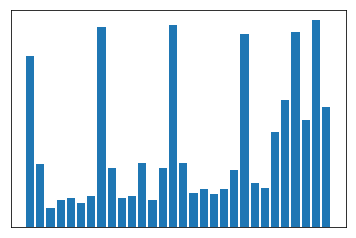

In [167]:
hhh = op_train_with_label[op_train_with_label['Tag']==1]['day'].value_counts().reset_index().sort_values(by='index')
X = np.array(hhh['index'])
Y1 = np.array(hhh['day'])/4285
# Y2 = np.log(np.array(op1))

plt.bar(X, +Y1)
# plt.bar(X, -Y2)

# plt.xlim(1, 30)
plt.xticks(())
# plt.ylim(-1.25, 1.25)
plt.yticks(())

plt.show()

In [172]:
Y1= np.array([2.53815636, 0.94095683, 0.28541424, 0.40630105, 0.43663944,
       0.36196033, 0.45670945, 2.96266044, 0.8798133 , 0.43407235,
       0.4697783 , 0.94679113, 0.39719953, 0.8798133 , 3.00466744,
       0.95612602, 0.50968495, 0.56849475, 0.49101517, 0.56429405,
       0.84574096, 2.85764294, 0.65344224, 0.58179697, 1.41306884,
       1.8798133 , 2.88961494, 1.59649942, 3.06907818, 1.77992999])

In [173]:
Y2 = np.array([2.81029226, 1.96263107, 1.08001785, 0.93764408, 1.23867777,
       1.0391909 , 1.0190377 , 3.21986317, 1.61389157, 1.04818919,
       0.66022161, 0.73600059, 0.83751023, 1.0111549 , 3.75414591,
       2.51870306, 1.34926006, 1.31241169, 1.288094  , 1.42991002,
       0.99762029, 3.42347736, 2.23425299, 1.00550309, 1.23395553,
       1.04633004, 1.19896631, 1.02970923, 3.39094222, 2.14598052])

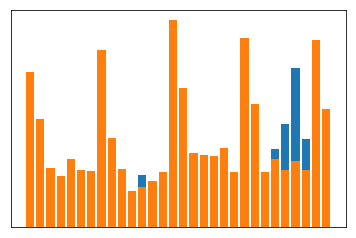

In [177]:
plt.bar(X, +Y1)
# plt.bar(X, -Y2)

# plt.xlim(1, 30)
plt.xticks(())
# plt.ylim(-1.25, 1.25)
plt.yticks(())

plt.show()

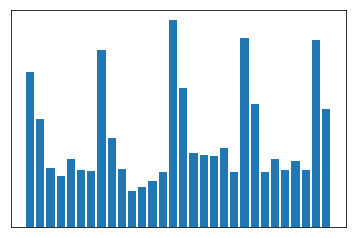

In [169]:
hhh = op_train_with_label[op_train_with_label['Tag']==0]['day'].value_counts().reset_index().sort_values(by='index')
X = np.array(hhh['index'])
Y1 = np.array(hhh['day'])/26894
# Y2 = np.log(np.array(op1))

plt.bar(X, +Y1)
# plt.bar(X, -Y2)

# plt.xlim(1, 30)
plt.xticks(())
# plt.ylim(-1.25, 1.25)
plt.yticks(())

plt.show()

## TRANS

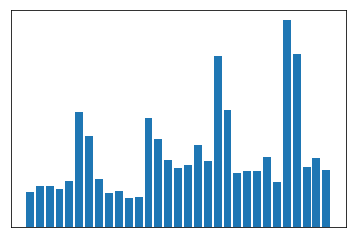

In [210]:
hhh = trans_test['day'].value_counts().reset_index().sort_values(by='index')
X = np.array(hhh['index'])
Y1 = np.array(hhh['day'])
# Y2 = np.log(np.array(op1))

plt.bar(X, +Y1)
# plt.bar(X, -Y2)

# plt.xlim(1, 30)
plt.xticks(())
# plt.ylim(-1.25, 1.25)
plt.yticks(())

plt.show()

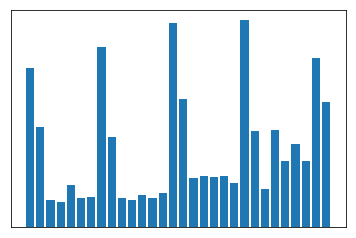

In [211]:
hhh = trans_train['day'].value_counts().reset_index().sort_values(by='index')
X = np.array(hhh['index'])
Y1 = np.array(hhh['day'])
# Y2 = np.log(np.array(op1))

plt.bar(X, +Y1)
# plt.bar(X, -Y2)

# plt.xlim(1, 30)
plt.xticks(())
# plt.ylim(-1.25, 1.25)
plt.yticks(())

plt.show()

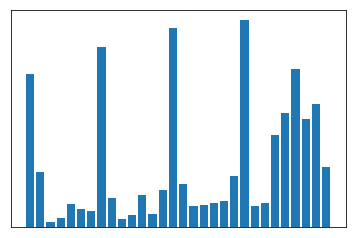

In [212]:
hhh = trans_train_with_label[trans_train_with_label['Tag']==1]['day'].value_counts().reset_index().sort_values(by='index')
X = np.array(hhh['index'])
Y1 = np.array(hhh['day'])
# Y2 = np.log(np.array(op1))

plt.bar(X, +Y1)
# plt.bar(X, -Y2)

# plt.xlim(1, 30)
plt.xticks(())
# plt.ylim(-1.25, 1.25)
plt.yticks(())

plt.show()

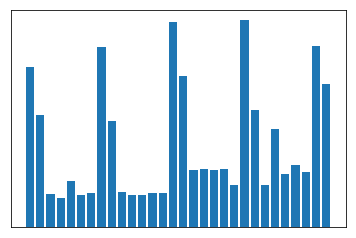

In [213]:
hhh = trans_train_with_label[trans_train_with_label['Tag']==0]['day'].value_counts().reset_index().sort_values(by='index')
X = np.array(hhh['index'])
Y1 = np.array(hhh['day'])
# Y2 = np.log(np.array(op1))

plt.bar(X, +Y1)
# plt.bar(X, -Y2)

# plt.xlim(1, 30)
plt.xticks(())
# plt.ylim(-1.25, 1.25)
plt.yticks(())

plt.show()

## HOUR

In [334]:
hour = op_train_with_label['time'].map(lambda x:x[:2])

In [226]:
for hour, subdf in op_train_with_label.groupby(hour):
    print("Hour {}:".format(hour))
    for tag, subdf2 in subdf.groupby(['Tag']):
        print(tag, subdf2.shape[0], subdf2['UID'].unique().size)

Hour 00:
0 15883 1971
1 1419 290
Hour 01:
0 7184 1047
1 935 193
Hour 02:
0 3980 630
1 725 248
Hour 03:
0 2762 488
1 398 176
Hour 04:
0 4790 644
1 705 286
Hour 05:
0 12615 1400
1 539 203
Hour 06:
0 29600 2873
1 1027 165
Hour 07:
0 55914 5046
1 4311 604
Hour 08:
0 93465 7602
1 8383 808
Hour 09:
0 104418 9100
1 11851 1239
Hour 10:
0 108764 9711
1 14400 1588
Hour 11:
0 87651 8624
1 13192 1523
Hour 12:
0 77350 7983
1 8198 1296
Hour 13:
0 64258 7023
1 10477 1456
Hour 14:
0 70308 7340
1 11422 1568
Hour 15:
0 76994 8120
1 12236 1501
Hour 16:
0 82099 8520
1 10276 1357
Hour 17:
0 80244 8265
1 10241 1293
Hour 18:
0 71923 7715
1 9253 1088
Hour 19:
0 67247 7369
1 7713 949
Hour 20:
0 65826 7293
1 4994 638
Hour 21:
0 57286 6553
1 5702 833
Hour 22:
0 41186 4894
1 4350 722
Hour 23:
0 24591 3275
1 1758 280


In [233]:
x = []
op0 = []
u0 = []
op1 = []
u1 = []
for h, subdf in op_train_with_label.groupby(hour):
    x.append(int(h))
    for tag, subdf2 in subdf.groupby(['Tag']):
        if tag == 0:
            op0.append(subdf2.shape[0])
            u0.append(subdf2['UID'].unique().size)
        else:
            op1.append(subdf2.shape[0])
            u1.append(subdf2['UID'].unique().size)

In [240]:
X

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

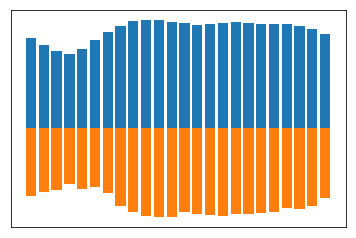

In [242]:
X = np.array(x)
Y1 = np.log(np.array(op0))
Y2 = np.log(np.array(op1))

plt.bar(X, +Y1)
plt.bar(X, -Y2)

# plt.xlim(-.5, n)
plt.xticks(())
# plt.ylim(-1.25, 1.25)
plt.yticks(())

plt.show()

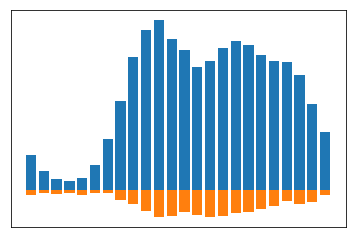

In [244]:
Y1 = np.array(u0)
Y2 = np.array(u1)

plt.bar(X, +Y1)
plt.bar(X, -Y2)

# plt.xlim(-.5, n)
plt.xticks(())
# plt.ylim(-1.25, 1.25)
plt.yticks(())

plt.show()

# Transaction overview

In [185]:
result = []
for feature in trans_train_with_label.columns[1:-1]:
    if feature in ['time', 'day']:
        continue
    a = trans_train_with_label.groupby([feature])['UID'].unique()
    cnt = 0
    same = 0
    same1 = 0
    for i in range(a.size):
        if a.iloc[i].size>1:
            cnt+=1
            crt = y[y['UID'].isin(list(a.iloc[i]))].Tag.mean()
            if crt==0 or crt==1:
                same+=1
                if crt==1:
                    same1+=1
    result.append((feature,a.size,cnt,same,same1))
    print(feature,a.size,cnt,same, same1)
result = pd.DataFrame(result,columns=['feature','feature_nunique','>1user_nunique','same_nunique', 'same1_nunique'])

channel 5 5 2 1
day 30 30 0 0
trans_amt 11225 4865 3325 51
amt_src1 28 28 11 1
merchant 19766 4391 3579 766
code1 6101 1561 1501 1328
code2 668 83 82 4
trans_type1 15 15 4 0
acc_id1 27630 1356 1171 618
device_code1 28601 911 818 84
device_code2 28234 744 681 97
device_code3 7221 275 238 120
device1 2566 282 188 14
device2 1697 1076 560 36
mac1 18545 716 627 115
ip1 76902 6523 5335 650
bal 12307 3010 1324 373
amt_src2 115 101 65 2
acc_id2 9887 748 694 190
acc_id3 13713 339 321 276
geo_code 3628 2335 1903 6
trans_type2 4 4 0 0
market_code 430 305 246 3
market_type 2 2 0 0
ip1_sub 23660 9142 7002 204


In [177]:
for cha, subdf in trans_train_with_label.groupby(['channel']):
    crt = subdf.Tag.mean()
    if crt==0 or crt == 1:
        print(cha,crt,subdf['UID'].unique().size)

118 1.0 1371
119 0.0 246


In [307]:
trans_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264654 entries, 0 to 264653
Data columns (total 27 columns):
UID             264654 non-null int64
channel         264654 non-null int64
day             264654 non-null int64
time            264654 non-null float64
trans_amt       264654 non-null int64
amt_src1        264654 non-null object
merchant        264654 non-null object
code1           24875 non-null object
code2           3219 non-null object
trans_type1     264654 non-null object
acc_id1         100318 non-null object
device_code1    174139 non-null object
device_code2    167096 non-null object
device_code3    43626 non-null object
device1         217088 non-null object
device2         225609 non-null object
mac1            173444 non-null object
ip1             225926 non-null object
bal             264654 non-null int64
amt_src2        141939 non-null object
acc_id2         28752 non-null object
acc_id3         28989 non-null object
geo_code        197194 non-null object
tr

In [306]:
for os, subdf in trans_train_with_label.groupby(['trans_type1']):
    crt = subdf.Tag.mean()
    if crt>=0.14:
        print(os,crt,subdf['UID'].unique().size)

61bfb66c928f36ac 0.40669959201202494 5948
6d55c54c8b1056fb 0.3883473237656828 7141
ced62357ad496957 0.7437837837837837 115


In [291]:
for feature in trans_train_with_label.columns[1:-1]:
    if feature in ['time', 'day', 'success']:
        continue
    mean_rate = []
    concat_df = []
    for key, subdf in trans_train_with_label.groupby([feature]):
        a = subdf['UID'].unique()
        if a.size<2:
            continue
        crt = y[y['UID'].isin(list(a))].Tag.mean()
        if crt>0:
            mean_rate.append(crt)
            concat_df.append(y[y['UID'].isin(list(a))])
    df = pd.concat(concat_df)
    print(feature, df.Tag.mean(), np.mean(np.array(mean_rate)))

channel 0.16739156846069736 0.34876814381559645
trans_amt 0.11737996763172091 0.23071860636481228
amt_src1 0.14288154972335756 0.19422344945641634
merchant 0.340944189693269 0.6874069642741281
code1 0.9832561453509084 0.9799505969534786
code2 0.8666666666666667 0.8666666666666666
trans_type1 0.15908022483392947 0.15889575316974788
acc_id1 0.7366504854368932 0.8905381576876493
device_code1 0.7991886409736308 0.7177322718006502
device_code2 0.9224334600760457 0.8269165841329563
device_code3 0.9215481171548117 0.8980562732717098
device1 0.13058913542463657 0.4075144947709568
device2 0.15046519088867502 0.2714301311195534
mac1 0.14000384098329172 0.761438284837122
ip1 0.624184298991497 0.6322079149830011
bal 0.378404867889084 0.632701195692554
amt_src2 0.17531634424291212 0.1637338728361724
acc_id2 0.9438920454545454 0.9109627632059895
acc_id3 0.9729144095341279 0.9720332577475435
geo_code 0.18617295255537114 0.24302743771463342
trans_type2 0.17076053009200642 0.2245493773955107
market_cod

# Feature Dictionary

In [14]:
feature_dic = defaultdict(lambda: defaultdict(list))#[feature,feature_value]
op_key = ['device_code1', 'device_code2', 'device_code3', 'mac1',
'ip1','geo_code','ip1_sub','mac2', 'ip2', 'wifi', 'ip2_sub']
trans_key = ['device_code1','device_code2', 'device_code3',  'mac1', 'ip1',
'geo_code', 'ip1_sub',  'merchant','code1', 'code2', 'acc_id1', 
'acc_id2', 'acc_id3']#'trans_amt',

In [15]:
for feature in op_key:
    for feature_value, subdf in op_all.groupby([feature]):
        feature_dic[feature][feature_value] += list(subdf['UID'].unique())
        feature_dic[feature][feature_value] = list(set(feature_dic[feature][feature_value]))
for feature in trans_key:
    for feature_value, subdf in trans_all.groupby([feature]):
        feature_dic[feature][feature_value] += list(subdf['UID'].unique())
        feature_dic[feature][feature_value] = list(set(feature_dic[feature][feature_value]))

## 整合

In [16]:
for feature in ['acc_id1', 'acc_id2', 'acc_id3']:
    for feature_value, subdf in trans_all.groupby([feature]):
        feature_dic['acc_id'][feature_value] += list(subdf['UID'].unique())
        feature_dic['acc_id'][feature_value] = list(set(feature_dic['acc_id'][feature_value]))

In [17]:
for feature in ['device_code1', 'device_code2', 'device_code3']:
    for feature_value, subdf in trans_all.groupby([feature]):
        feature_dic['device_code'][feature_value+feature[-1]] += list(subdf['UID'].unique())
        feature_dic['device_code'][feature_value+feature[-1]] \
        = list(set(feature_dic['device_code'][feature_value+feature[-1]]))

# Feature Engineering

In [18]:
mode_1 = ['08017d2cb28c2348', '270ca3ca8f0d1126',
'2e6fdb7d4ddef57f', '2f3e878175e34d9c',
'ac63e881c4e19402', 'd25caee90b27fa9b',
'8c7ce5ff939e66d1', '8e463287d7146285',
'963bd8a75ff9ab37', '9c69742a831d6214']
mode_2 = ['79f8b86938180c3c']
mode_3 = ['acfaded7e04e7ba0']
mode_4 = ['9faf791e291fe4a1','a3f0d631c4fcaf38',
'a698c1862f390021', 'e00efcf34eb17f69',
'2e7e5808ff6323e8', '385608c64026c669',
'8b259df485199a2b']

version_1 = ['4.1.7','6.1.0',
'6.5.0','6.6.3','7.0.0']
version_2 = ['7.0.7']

# 记得加上整合feature ！！！
op_feature = ['mac2','ip2','wifi', 'ip2_sub']
trans_feature = ['merchant', 'code1', 'code2', 'acc_id1', 
'acc_id2', 'acc_id3', 'acc_id']#'trans_amt', 
common_feature = ['device_code1','device_code2', 'device_code3', 'mac1', 'ip1',
'geo_code', 'ip1_sub']#device_code

In [21]:
y[y['UID'].isin([1000])].shape[0]

0

In [19]:
def get_op_feature(op):
    uid = []

    md1 = []
    md2 = []
    md3 = []
    md4 = []
    md_res = []

    vr1 = []
    vr2 = []
    vr_res = []

    os_list = []
    for i in range(7):
        os_list.append([])
        
    feature_list = defaultdict(list)

    for u, subdf in op.groupby(['UID']):
        uid.append(u)
        #mode feature
        mode1_cnt = 0
        mode2_cnt = 0
        mode3_cnt = 0
        mode4_cnt = 0
        mode_res_cnt = 0
        tmp = subdf['mode'].value_counts()
        for idx in tmp.index:
            if idx in mode_1:
                mode1_cnt += tmp.loc[idx]
            elif idx in mode_2:
                mode2_cnt += tmp.loc[idx]
            elif idx in mode_3:
                mode3_cnt += tmp.loc[idx]
            elif idx in mode_4:
                mode4_cnt += tmp.loc[idx]
            else:
                mode_res_cnt += tmp.loc[idx]
        md1.append(mode1_cnt)
        md2.append(mode2_cnt)
        md3.append(mode3_cnt)
        md4.append(mode4_cnt)
        md_res.append(mode_res_cnt)

        #version feature
        v1_cnt = 0
        v2_cnt = 0
        v_res_cnt = 0
        tmp = subdf['version'].value_counts()
        for idx in tmp.index:
            if idx in version_1:
                v1_cnt += tmp.loc[idx]
            elif idx in version_2:
                v2_cnt += tmp.loc[idx]
            else:
                v_res_cnt += tmp.loc[idx]
        vr1.append(v1_cnt)
        vr2.append(v2_cnt)
        vr_res.append(v_res_cnt)

        #os feature
        os_cnt = []
        for i in range(7):
            os_cnt.append(0)
        tmp = subdf['os'].unique().tolist()
        for idx in tmp:
            if idx==101:
                os_cnt[0]=1
            elif idx==102:
                os_cnt[1]=1
            elif idx==103:
                os_cnt[2]=1
            elif idx==104:
                os_cnt[3]=1
            elif idx==105:
                os_cnt[4]=1
            elif idx==107:
                os_cnt[5]=1
            elif idx==200:
                os_cnt[6]=1
        for i in range(7):
            os_list[i].append(os_cnt[i])
        #other op feature
        for feature in op_feature:
            values = subdf[feature].unique().tolist()
            result = []
            for value in values:
                l = feature_dic[feature][value].copy()
                l = list(set(l)-{u})
                udf = y[y['UID'].isin(list(l))]
                if udf.shape[0]>0:
                    result.append(udf.Tag.mean())
            if len(result)<1:
                feature_list[feature+'_max'].append(np.nan)
                feature_list[feature+'_min'].append(np.nan)
                feature_list[feature+'_mean'].append(np.nan)
            else:
                feature_list[feature+'_max'].append(np.max(result))
                feature_list[feature+'_min'].append(np.min(result))
                feature_list[feature+'_mean'].append(np.mean(result))
    fff = pd.DataFrame({'UID':uid, 'mode1_cnt':md1, 'mode2_cnt':md2, 'mode3_cnt':md3,
                             'mode4_cnt':md4, 'mode_res_cnt':md_res, 'version1_cnt':vr1,
                              'version2_cnt':vr2, 'version_res_cnt':vr_res, 'os1_cnt':os_list[0],
                             'os2_cnt':os_list[1],'os3_cnt':os_list[2],'os4_cnt':os_list[3],
                             'os5_cnt':os_list[4],'os6_cnt':os_list[5],'os7_cnt':os_list[6]
                            })
    for feature in op_feature:
        fff[feature+'_max'] = feature_list[feature+'_max']
        fff[feature+'_min'] = feature_list[feature+'_min']
        fff[feature+'_mean'] = feature_list[feature+'_mean']
    return fff

In [20]:
def get_trans_feature(trans):
    uid = []
    
    channel = []
    for i in range(5):
        channel.append([])

    tr_2 = []
    for i in range(4):
        tr_2.append([])

    mar1 = []
    mar2 = []   
    
    feature_list = defaultdict(list)

    for u, subdf in trans.groupby(['UID']):
        uid.append(u)
        #channel feature
        ch_cnt = []
        for i in range(5):
            ch_cnt.append(0)
        tmp = subdf['channel'].value_counts()
        for idx in tmp.index:
            if idx == 102:
                ch_cnt[0] += tmp.loc[idx]
            elif idx == 106:
                ch_cnt[1] += tmp.loc[idx]
            elif idx == 118:
                ch_cnt[2] += tmp.loc[idx]
            elif idx == 119:
                ch_cnt[3] += tmp.loc[idx]
            elif idx == 140:
                ch_cnt[4] += tmp.loc[idx]
        for i in range(5):
            channel[i].append(ch_cnt[i])
        #trans_type2 feature
        tr_2_cnt = []
        for i in range(4):
            tr_2_cnt.append(0)
        tmp = subdf['channel'].value_counts()
        for idx in tmp.index:
            if idx == 102:
                tr_2_cnt[0] += tmp.loc[idx]
            elif idx == 103:
                tr_2_cnt[1] += tmp.loc[idx]
            elif idx == 104:
                tr_2_cnt[2] += tmp.loc[idx]
            elif idx == 105:
                tr_2_cnt[3] += tmp.loc[idx]
        for i in range(4):
            tr_2[i].append(tr_2_cnt[i])
        #market_type feature
        mar1_cnt = 0
        mar2_cnt = 0
        tmp = subdf['market_type'].value_counts()
        for idx in tmp.index:
            if idx == 1:
                mar1_cnt += tmp.loc[idx]
            elif idx == 2:
                mar2_cnt += tmp.loc[idx]
        mar1.append(mar1_cnt)
        mar2.append(mar2_cnt)
        
        for feature in trans_feature:
            if feature == 'acc_id':
                values = list(set(subdf['acc_id1'].unique().tolist() \
                + subdf['acc_id2'].unique().tolist() \
                + subdf['acc_id3'].unique().tolist()))
            else:
                values = subdf[feature].unique().tolist()
            result = []
            for value in values:
                l = feature_dic[feature][value].copy()
                l = list(set(l)-{u})
                
                udf = y[y['UID'].isin(list(l))]
                if udf.shape[0]>0:
                    result.append(udf.Tag.mean())

            if len(result)<1:
                feature_list[feature+'_max'].append(np.nan)
                feature_list[feature+'_min'].append(np.nan)
                feature_list[feature+'_mean'].append(np.nan)
            else:
                feature_list[feature+'_max'].append(np.max(result))
                feature_list[feature+'_min'].append(np.min(result))
                feature_list[feature+'_mean'].append(np.mean(result))
    fff = pd.DataFrame({'UID':uid, 'market_type_1_cnt':mar1, 'market_type_2_cnt':mar2
                            })
    for i in range(5):
        fff['channel_{}_cnt'.format(i+1)]=channel[i]
    for i in range(4):
        fff['trans_type2_{}_cnt'.format(i+1)]=tr_2[i]
    for feature in trans_feature:
        fff[feature+'_max'] = feature_list[feature+'_max']
        fff[feature+'_min'] = feature_list[feature+'_min']
        fff[feature+'_mean'] = feature_list[feature+'_mean']
    return fff

In [21]:
def get_common_feature(op, trans):
    uid = []
    feature_list = defaultdict(list)
    
    tmp = pd.concat([op[common_feature+['UID']],trans[common_feature+['UID']]]).groupby(['UID'])
    for u, subdf in tmp:
        uid.append(u)
        for feature in common_feature+['device_code']:
            if feature == 'device_code':
                values = list(set((subdf['device_code1']+'1').unique().tolist() \
                + (subdf['device_code2']+'2').unique().tolist() \
                + (subdf['device_code3']+'3').unique().tolist()))
            else:
                values = subdf[feature].unique().tolist()
            result = []
            for value in values:
                l = feature_dic[feature][value].copy()
                l = list(set(l)-{u})
                
                udf = y[y['UID'].isin(list(l))]
                if udf.shape[0]>0:
                    result.append(udf.Tag.mean())

            if len(result)<1:
                feature_list[feature+'_max'].append(np.nan)
                feature_list[feature+'_min'].append(np.nan)
                feature_list[feature+'_mean'].append(np.nan)
            else:
                feature_list[feature+'_max'].append(np.max(result))
                feature_list[feature+'_min'].append(np.min(result))
                feature_list[feature+'_mean'].append(np.mean(result))
    fff = pd.DataFrame({'UID':uid})
    for feature in common_feature+['device_code']:
        fff[feature+'_max'] = feature_list[feature+'_max']
        fff[feature+'_min'] = feature_list[feature+'_min']
        fff[feature+'_mean'] = feature_list[feature+'_mean']
    return fff

In [46]:
aaa=get_common_feature(op_train, trans_train)
aaa1 = get_common_feature(op_test, trans_test)
bbb = get_op_feature(op_train)
bbb1 = get_op_feature(op_test)
ccc = get_trans_feature(trans_train)
ccc1 = get_trans_feature(trans_test)

NameError: name 'get_common_feature' is not defined

## Save and load

In [23]:
aaa.to_csv('../feature/train_common_feature.csv',index=False)

In [24]:
aaa1.to_csv('../feature/test_common_feature.csv',index=False)
bbb.to_csv('../feature/train_op_feature.csv',index=False)
bbb1.to_csv('../feature/test_op_feature.csv',index=False)
ccc.to_csv('../feature/train_trans_feature.csv',index=False)
ccc1.to_csv('../feature/test_trans_feature.csv',index=False)

In [47]:
aaa = pd.read_csv('../feature/train_common_feature.csv')
aaa1 = pd.read_csv('../feature/test_common_feature.csv')
bbb = pd.read_csv('../feature/train_op_feature.csv')
bbb1 = pd.read_csv('../feature/test_op_feature.csv')
ccc = pd.read_csv('../feature/train_trans_feature.csv')
ccc1 = pd.read_csv('../feature/test_trans_feature.csv')

In [35]:
(aaa.count()/31179).sort_values(ascending=False)

UID                  1.000000
ip1_sub_mean         0.951442
ip1_sub_min          0.951442
ip1_sub_max          0.951442
geo_code_mean        0.914622
geo_code_min         0.914622
geo_code_max         0.914622
ip1_mean             0.569742
ip1_min              0.569742
ip1_max              0.569742
mac1_min             0.384265
mac1_max             0.384265
mac1_mean            0.384265
device_code_min      0.125597
device_code_max      0.125597
device_code_mean     0.125597
device_code1_mean    0.104654
device_code1_min     0.104654
device_code1_max     0.104654
device_code2_mean    0.086276
device_code2_min     0.086276
device_code2_max     0.086276
device_code3_mean    0.065942
device_code3_min     0.065942
device_code3_max     0.065942
dtype: float64

In [36]:
(bbb.count()/31179).sort_values(ascending=False)

version1_cnt       0.953462
os7_cnt            0.953462
mode1_cnt          0.953462
mode2_cnt          0.953462
mode3_cnt          0.953462
mode4_cnt          0.953462
mode_res_cnt       0.953462
os1_cnt            0.953462
os2_cnt            0.953462
os3_cnt            0.953462
os4_cnt            0.953462
os5_cnt            0.953462
os6_cnt            0.953462
UID                0.953462
version2_cnt       0.953462
version_res_cnt    0.953462
mac2_max           0.363354
mac2_min           0.363354
mac2_mean          0.363354
wifi_max           0.319542
wifi_min           0.319542
wifi_mean          0.319542
ip2_sub_min        0.156868
ip2_sub_max        0.156868
ip2_sub_mean       0.156868
ip2_max            0.026171
ip2_min            0.026171
ip2_mean           0.026171
dtype: float64

In [37]:
(ccc.count()/31179).sort_values(ascending=False)

UID                  0.979570
channel_4_cnt        0.979570
trans_type2_4_cnt    0.979570
trans_type2_3_cnt    0.979570
trans_type2_2_cnt    0.979570
channel_5_cnt        0.979570
trans_type2_1_cnt    0.979570
channel_3_cnt        0.979570
channel_2_cnt        0.979570
channel_1_cnt        0.979570
market_type_2_cnt    0.979570
market_type_1_cnt    0.979570
merchant_mean        0.905481
merchant_max         0.905481
merchant_min         0.905481
code2_mean           0.905193
code2_min            0.905193
code2_max            0.905193
code1_min            0.904166
code1_max            0.904166
code1_mean           0.904166
acc_id_min           0.121460
acc_id_max           0.121460
acc_id_mean          0.121460
acc_id1_max          0.114821
acc_id1_min          0.114821
acc_id1_mean         0.114821
acc_id2_max          0.057378
acc_id2_min          0.057378
acc_id2_mean         0.057378
acc_id3_max          0.017416
acc_id3_min          0.017416
acc_id3_mean         0.017416
dtype: flo

## Xgb node Feature

In [51]:
from utils.xgb_feature import XgboostFeature

In [52]:
xgb_f = XgboostFeature()

Xgboost Feature start, new_feature number: 30


## Graph Feature

In [42]:
import networkx as nx

In [43]:
from itertools import combinations

In [19]:
group_feature = ['device_code', 'acc_id', 'device_code_and_acc_id', 
                 'device_code_acc_id_and_ip2', 'device_code_acc_id_ip2_and_ip2sub']
group_dic = {'device_code':['device_code1', 'device_code2', 'device_code3'],
            'acc_id':['acc_id1', 'acc_id2', 'acc_id3'],
             'device_code_and_acc_id':['device_code1', 'device_code2', 'device_code3', 
                                       'acc_id1', 'acc_id2', 'acc_id3'],
             'device_code_acc_id_and_ip2':['device_code1', 'device_code2', 'device_code3', 
                                       'acc_id1', 'acc_id2', 'acc_id3', 'ip2'],
             'device_code_acc_id_ip2_and_ip2sub':['device_code1', 'device_code2', 'device_code3', 
                                       'acc_id1', 'acc_id2', 'acc_id3', 'ip2', 'ip2_sub']
            }

graph_feature = ['device_code', 'acc_id', 'device_code_and_acc_id', 
                 'device_code_acc_id_and_ip2', 'device_code_acc_id_ip2_and_ip2sub',
                 
                'device_code1','device_code2', 'device_code3',  'ip1',
                  'ip2','wifi', 'ip2_sub',  'acc_id1', 
                'acc_id2', 'acc_id3']#'ip1_sub','geo_code','merchant', 'code1', 'code2', 'mac1','mac2'

In [48]:
for feature in graph_feature:
    if feature in group_feature:
        continue
    l_cnt = 0
    cnt = 0
    for f_v, l in feature_dic[feature].items():
        cnt+=1
        l_cnt+=len(l)
    print(feature, l_cnt/cnt)

device_code1 1.1069463608893857
device_code2 1.0694159310203244
device_code3 1.3647794557913646
mac1 1.671747548817665
ip1 1.2289143503741062
geo_code 14.325978119784907
ip1_sub 4.779641933779989
mac2 1.7647184357243844
ip2 1.0593639433901576
wifi 1.3432738084703466
ip2_sub 2.0491286531273922
merchant 4.255200789993417
code1 3.4602946370011605
code2 4.210586208017687
acc_id1 1.124260119969809
acc_id2 1.1757865099767413
acc_id3 1.053645241880536


In [45]:
def get_second_order_neighbor(G, n):
    neighbors = list(G.adj[n])
    second_order_neighbors = []
    for neighbor in neighbors:
        second_order_neighbors += list(G.adj[neighbor])
    second_order_neighbors = set(second_order_neighbors)
    second_order_neighbors -= set(neighbors)
    second_order_neighbors -= {n}
    return list(second_order_neighbors)

In [51]:
def get_graph_feature(UID):
    feature_list = defaultdict(list)
    if os.path.exists('../feature/graph_feature.csv'):
        result = pd.read_csv('../feature/graph_feature.csv')
    else:
        result = pd.DataFrame({'UID':UID})
    G = nx.Graph()
    for feature in graph_feature:
        print(feature,'begin...')
        G.add_nodes_from(list(UID))
        #creat the graph
        if feature in group_feature:
            for fea in group_dic[feature]:
                for f_v, l in feature_dic[fea].items():
                    if len(l)>1:
                        G.add_edges_from(list(combinations(l, 2)))
        else:
            for f_v, l in feature_dic[feature].items():
                if len(l)>1:
                    G.add_edges_from(list(combinations(l, 2)))
        #feature extraction
        for u in UID:
            feature_list[feature+'_graph_num_1st_neighbor'].append(len(list(G.adj[u])))
            feature_list[feature+'_graph_component_size'].append(len(nx.node_connected_component(G, u)))
            sec_order_neighbors = get_second_order_neighbor(G, u)
            feature_list[feature+'_graph_num_2nd_neighbor'].append(len(sec_order_neighbors))
            if len(list(G.adj[u]))==0:
                feature_list[feature+'_graph_Prate_1st_neighbor'].append(np.nan)
                feature_list[feature+'_graph_Prate_component'].append(np.nan)
            else:
                feature_list[feature+'_graph_Prate_1st_neighbor'].append(y[y['UID'].isin(list(G.adj[u]))].Tag.mean())
                feature_list[feature+'_graph_Prate_component'].append(y[y['UID'].isin(list(nx.node_connected_component(G, u)-{u}))].Tag.mean())
            if len(sec_order_neighbors)==0:
                feature_list[feature+'_graph_Prate_2nd_neighbor'].append(np.nan)
            else:
                feature_list[feature+'_graph_Prate_2nd_neighbor'].append(y[y['UID'].isin(sec_order_neighbors)].Tag.mean())
        result[feature+'_graph_num_1st_neighbor'] = feature_list[feature+'_graph_num_1st_neighbor']
        result[feature+'_graph_component_size'] = feature_list[feature+'_graph_component_size']
        result[feature+'_graph_num_2nd_neighbor'] = feature_list[feature+'_graph_num_2nd_neighbor']

        result[feature+'_graph_Prate_1st_neighbor'] = feature_list[feature+'_graph_Prate_1st_neighbor']
        result[feature+'_graph_Prate_component'] = feature_list[feature+'_graph_Prate_component']
        result[feature+'_graph_Prate_2nd_neighbor'] = feature_list[feature+'_graph_Prate_2nd_neighbor']
        G.clear()
        result.to_csv('../feature/graph_feature.csv', index=False)
        print(feature,'finish ! ! !')
    return result

In [41]:
all_UID = pd.concat([y.UID,sub.UID], ignore_index=True)

In [54]:
graph_feature = [
# 'device_code', 'acc_id', 'device_code_and_acc_id', 
#                  'device_code_acc_id_and_ip2', 'device_code_acc_id_ip2_and_ip2sub',
                 
#                 'device_code1','device_code2', 'device_code3',
                'ip2_sub',  'acc_id1', 
                'acc_id2', 'acc_id3','ip2',
    
                  'ip1','wifi',
                  ]#

In [ ]:
graph_feature = get_graph_feature(all_UID)

ip2_sub begin...
ip2_sub finish ! ! !
acc_id1 begin...
acc_id1 finish ! ! !
acc_id2 begin...
acc_id2 finish ! ! !
acc_id3 begin...
acc_id3 finish ! ! !
ip2 begin...
ip2 finish ! ! !
ip1 begin...
ip1 finish ! ! !
wifi begin...
wifi finish ! ! !
mac2 begin...


In [183]:
graph_feature = ['device_code', 'acc_id', 'device_code_and_acc_id', 
                 'device_code_acc_id_and_ip2', 'device_code_acc_id_ip2_and_ip2sub',
                 
                'device_code1','device_code2', 'device_code3',  'ip1',
                  'ip2','wifi', 'ip2_sub',  'acc_id1', 
                'acc_id2', 'acc_id3']#'ip1_sub','geo_code','merchant', 'code1', 'code2', 'mac1','mac2'

In [181]:
graph_all = pd.read_csv('../feature/graph_feature.csv')

In [184]:
for feature in graph_feature:
    graph_all[feature+'_graph_num_Psample_1st_neighbor'] = \
    graph_all[feature+'_graph_Prate_1st_neighbor']*graph_all[feature+'_graph_num_1st_neighbor']
    
    graph_all[feature+'_graph_num_Psample_2nd_neighbor'] = \
    graph_all[feature+'_graph_Prate_2nd_neighbor']*graph_all[feature+'_graph_num_2nd_neighbor']
    
    graph_all[feature+'_graph_num_Psample_component'] = \
    graph_all[feature+'_graph_Prate_component']*graph_all[feature+'_graph_component_size']

In [191]:
graph_all.columns.shape

(91,)

In [189]:
for feature in graph_all.columns:
    if 'component' in feature:
        graph_all = graph_all.drop([feature], axis=1)

In [194]:
graph_train = graph_all[graph_all.UID.isin(y.UID)]
graph_test = graph_all[graph_all.UID.isin(sub.UID)]

In [121]:
bbb.head()

,UID,mode1_cnt,mode2_cnt,mode3_cnt,mode4_cnt,mode_res_cnt,os1_cnt,os2_cnt,os3_cnt,os4_cnt,os5_cnt,os6_cnt,os7_cnt,version1_cnt,version2_cnt,version_res_cnt,mac2_max,mac2_min,mac2_mean,ip2_max,ip2_min,ip2_mean,wifi_max,wifi_min,wifi_mean,ip2_sub_max,ip2_sub_min,ip2_sub_mean
0,10000,3,0,0,0,6,0,0,1,0,0,0,0,0,5,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,10,17,0,0,40,0,1,0,1,0,0,1,0,0,48,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2,10002,7,0,0,0,4,1,1,0,0,0,0,0,0,0,10,0.05754,0.05754,0.05754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10003,1,0,0,0,14,0,1,0,0,0,0,0,0,0,15,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
4,10004,2,0,3,0,29,0,1,0,0,0,0,0,0,0,34,0.05754,0.05754,0.05754,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN


In [60]:
aaa.head()

,UID,device_code1_max,device_code1_min,device_code1_mean,device_code2_max,device_code2_min,device_code2_mean,device_code3_max,device_code3_min,device_code3_mean,mac1_max,mac1_min,mac1_mean,ip1_max,ip1_min,ip1_mean,geo_code_max,geo_code_min,geo_code_mean,ip1_sub_max,ip1_sub_min,ip1_sub_mean,device_code_max,device_code_min,device_code_mean
0,10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN
1,10001,NaN,NaN,NaN,NaN,NaN,NaN,0.035088,0.035088,0.035088,NaN,NaN,NaN,NaN,NaN,NaN,0.033333,0.000000,0.011111,0.000000,0.000000,0.000000,NaN,NaN,NaN
2,10002,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.06666,0.06666,0.06666,0.0,0.0,0.0,0.047923,0.047923,0.047923,0.073171,0.073171,0.073171,0.0,0.0,0.0
3,10003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06666,0.06666,0.06666,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
4,10004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06666,0.06666,0.06666,NaN,NaN,NaN,0.030303,0.000000,0.015152,0.036364,0.000000,0.004545,NaN,NaN,NaN


In [187]:
graph_m_train = pd.read_csv('../feature/train_features_graph_first.csv')
graph_m_test = pd.read_csv('../feature/test_features_graph_first.csv')
graph_m_train = graph_m_train.drop(['Tag'], axis=1)

# Ration Feature

In [188]:
ration_train = pd.read_csv('../feature/ration_train.csv')
ration_test = pd.read_csv('../feature/ration_test.csv')

In [189]:
ration_train.head()

,UID,Tag,UIDip1_x,UIDip1_y,UIDmac1_x,UIDmac1_y,UIDmac2_x,UIDmac2_y,UIDgeo_code_x,UIDgeo_code_y,day_x,day_y,day_x.1,day_y.1,day_x.2,day_y.2,day_x.3,dayip1_x,dayip1_y,dayip1_x.1,dayip1_y.1,dayip1_x.2,dayip1_y.2,dayip1_x.3,daymac1_x,daymac1_y,daymac1_x.1,daymac1_y.1,daymac1_x.2,daymac1_y.2,daymac1_x.3,daymac2_x,daymac2_y,daymac2_x.1,daymac2_y.1,daymac2_x.2,daymac2_y.2,daymac2,mode_x,mode_y,modeip1_x,modeip1_y,modemac1_x,modemac1_y,modemac2_x,modemac2_y,modegeo_code_x,modegeo_code_y,success_x,success_y,successip1_x,successip1_y,successmac1_x,successmac1_y,successmac2_x,successmac2_y,successgeo_code_x,successgeo_code_y,time_x,time_y,timeip1_x,timeip1_y,timemac1_x,timemac1_y,timemac2_x,timemac2_y,timegeo_code_x,timegeo_code_y,os_x,os_y,osip1_x,osip1_y,osmac1_x,osmac1_y,osmac2_x,osmac2_y,osgeo_code_x,osgeo_code_y,version_x,version_y,versionip1_x,versionip1_y,versionmac1_x,versionmac1_y,versionmac2_x,versionmac2_y,versiongeo_code_x,versiongeo_code_y,device1_x,device1_y,device1ip1_x,device1ip1_y,device1mac1_x,device1mac1_y,device1mac2_x,device1mac2_y,device1geo_code_x,device1geo_code_y,device2_x,device2_y,device2ip1_x,device2ip1_y,device2mac1_x,device2mac1_y,device2mac2_x,device2mac2_y,device2geo_code_x,device2geo_code_y,device_code1_x,device_code1_y,device_code1ip1_x,device_code1ip1_y,device_code1mac1_x,device_code1mac1_y,device_code1mac2_x,device_code1mac2_y,device_code1geo_code_x,device_code1geo_code_y,device_code2_x,device_code2_y,device_code2ip1_x,device_code2ip1_y,device_code2mac1_x,device_code2mac1_y,device_code2mac2_x,device_code2mac2_y,device_code2geo_code_x,device_code2geo_code_y,device_code3_x,device_code3_y,device_code3ip1_x,device_code3ip1_y,device_code3mac1_x,device_code3mac1_y,device_code3mac2_x,device_code3mac2_y,device_code3geo_code_x,device_code3geo_code_y,mac1_x,mac1_y,mac1ip1_x,mac1ip1_y,mac1mac2_x,mac1mac2_y,mac1geo_code_x,mac1geo_code_y,mac2_x,mac2_y,mac2ip1_x,mac2ip1_y,mac2mac1_x,mac2mac1_y,mac2geo_code_x,mac2geo_code_y,ip1_x,ip1_y,ip1mac1_x,ip1mac1_y,ip1mac2_x,ip1mac2_y,ip1geo_code_x,ip1geo_code_y,ip2_x,ip2_y,ip2ip1_x,ip2ip1_y,ip2mac1_x,ip2mac1_y,ip2mac2_x,ip2mac2_y,ip2geo_code_x,ip2geo_code_y,wifi_x,wifi_y,wifiip1_x,wifiip1_y,wifimac1_x,wifimac1_y,wifimac2_x,wifimac2_y,wifigeo_code_x,wifigeo_code_y,geo_code_x,geo_code_y,geo_codeip1_x,geo_codeip1_y,geo_codemac1_x,geo_codemac1_y,geo_codemac2_x,geo_codemac2_y,ip1_sub_x,ip1_sub_y,ip1_subip1_x,ip1_subip1_y,ip1_submac1_x,ip1_submac1_y,ip1_submac2_x,ip1_submac2_y,ip1_subgeo_code_x,ip1_subgeo_code_y,ip2_sub_x,ip2_sub_y,ip2_subip1_x,ip2_subip1_y,ip2_submac1_x,ip2_submac1_y,ip2_submac2_x,ip2_submac2_y,ip2_subgeo_code_x,ip2_subgeo_code_y,channel_x,channel_y,channelmerchant_x,channelmerchant_y,channelip1_x,channelip1_y,channelmac1_x,channelmac1_y,channelgeo_code_x,channelgeo_code_y,day_y.3,day_x.4,day_y.4,day_x.5,day_y.5,day_x.6,day_y.6,daymerchant_x,daymerchant_y,daymerchant_x.1,daymerchant_y.1,daymerchant_x.2,daymerchant_y.2,daymerchant,dayip1_y.3,dayip1_x.4,dayip1_y.4,dayip1_x.5,dayip1_y.5,dayip1_x.6,dayip1_y.6,daymac1_y.3,daymac1_x.4,daymac1_y.4,daymac1_x.5,daymac1_y.5,daymac1_x.6,daymac1_y.6,time_x.1,time_y.1,timemerchant_x,timemerchant_y,timeip1_x.1,timeip1_y.1,timemac1_x.1,timemac1_y.1,timegeo_code_x.1,timegeo_code_y.1,trans_amt_x,trans_amt_y,trans_amt_x.1,trans_amt_y.1,trans_amt_x.2,trans_amt_y.2,trans_amt,trans_amtmerchant_x,trans_amtmerchant_y,trans_amtmerchant_x.1,trans_amtmerchant_y.1,trans_amtmerchant_x.2,trans_amtmerchant_y.2,trans_amtmerchant,trans_amtip1_x,trans_amtip1_y,trans_amtip1_x.1,trans_amtip1_y.1,trans_amtip1_x.2,trans_amtip1_y.2,trans_amtip1,trans_amtmac1_x,trans_amtmac1_y,trans_amtmac1_x.1,trans_amtmac1_y.1,trans_amtmac1_x.2,trans_amtmac1_y.2,trans_amtmac1,amt_src1_x,amt_src1_y,amt_src1merchant_x,amt_src1merchant_y,amt_src1ip1_x,amt_src1ip1_y,amt_src1mac1_x,amt_src1mac1_y,amt_src1geo_code_x,amt_src1geo_code_y,merchant_x,merchant_y,merchantip1_x,merchantip1_y,merchantmac1_x,merchantmac1_y,merchantgeo_code_x,merchantgeo_code_y,code1_x,code1_y,code1m

In [191]:
ration_train.shape

(31179, 516)

In [ ]:
ration_train = ration_train.drop(['Tag'],axis = 1).fillna(-1)
ration_test = ration_test.drop(['Tag'],axis = 1).fillna(-1)

# Process

In [18]:
sub = generate_test_sub()

In [19]:
sub.head()

,UID
0,30000
1,30001
2,30002
3,30003
4,30004


In [146]:
tw_train = get_time_window_feature(op_train, trans_train, y, True)
tw_test = get_time_window_feature(op_test, trans_test, sub, False)
tw_train = tw_train.drop(['Tag'], axis=1)
tw_test = tw_test.drop(['Tag'], axis=1)

In [308]:
train_baseline_feature = get_baseline_feature(op_train,trans_train,y)
test_baseline_feature = get_baseline_feature(op_test,trans_test,sub)
train_modified_feature = get_modified_feature(op_train,trans_train,y)
test_modified_feature = get_modified_feature(op_test,trans_test,sub)

In [31]:
train_modified_feature = get_modified_feature(op_train,trans_train,y)
test_modified_feature = get_modified_feature(op_test,trans_test,sub)

In [52]:
train_modified_feature = pd.read_csv('../feature/train_baseline_m_feature.csv')
test_modified_feature = pd.read_csv('../feature/test_baseline_m_feature.csv')
train_modified_feature[['day_count_x','day_count_y']] = train_modified_feature[['day_count_x','day_count_y']].fillna(0)
test_modified_feature[['day_count_x','day_count_y']] = test_modified_feature[['day_count_x','day_count_y']].fillna(0)
train_modified_feature['trans/op'] = train_modified_feature['day_count_y']/(train_modified_feature['day_count_x']+1)
test_modified_feature['trans/op'] = test_modified_feature['day_count_y']/(test_modified_feature['day_count_x']+1)

In [32]:
train_modified_feature.to_csv('../feature/train_baseline_m_feature.csv', index=False)
test_modified_feature.to_csv('../feature/test_baseline_m_feature.csv', index=False)

In [ ]:
train_baseline_feature.drop([])

In [185]:
(train_baseline_feature.count()/31179).sort_values(ascending=False)

UID                       1.000000
Tag                       1.000000
trans_type1_count         0.979570
amt_src1_nunique          0.979570
merchant_count            0.979570
merchant_nunique          0.979570
code1_count               0.979570
code1_nunique             0.979570
code2_count               0.979570
code2_nunique             0.979570
trans_type1_nunique       0.979570
ip1_sub_count_y           0.979570
acc_id1_count             0.979570
acc_id1_nunique           0.979570
device_code1_count_y      0.979570
device_code1_nunique_y    0.979570
device_code2_count_y      0.979570
device_code2_nunique_y    0.979570
device_code3_count_y      0.979570
amt_src1_count            0.979570
trans_amt_mean            0.979570
device1_count_y           0.979570
time_nunique_y            0.979570
day_count                 0.979570
day_nunique               0.979570
day_max                   0.979570
day_min                   0.979570
day_sum                   0.979570
day_mean            

In [434]:
(train_modified_feature.count()/31179).sort_values(ascending=False)

UID                     1.000000
Tag                     1.000000
merchant_nunique        0.979570
trans_amt_nunique       0.979570
trans_amt_max           0.979570
trans_amt_min           0.979570
trans_amt_sum           0.979570
trans_amt_mean          0.979570
amt_src1_count          0.979570
amt_src1_nunique        0.979570
merchant_count          0.979570
code1_count             0.979570
time_mean_y             0.979570
code1_nunique           0.979570
code2_count             0.979570
code2_nunique           0.979570
trans_type1_count       0.979570
trans_type1_nunique     0.979570
acc_id1_count           0.979570
acc_id1_nunique         0.979570
device_code1_count_y    0.979570
trans_amt_count         0.979570
time_sum_y              0.979570
device_code2_count_y    0.979570
day_max                 0.979570
channel_count           0.979570
channel_nunique         0.979570
channel_max             0.979570
channel_min             0.979570
channel_sum             0.979570
          

In [420]:
train = train_baseline_feature
test = train_baseline_feature

## Feature Merge

In [112]:
for feature in graph_m_train.columns:
    if 'ip1' in feature:#(('merchant' in feature) or ('code1' in feature) or ('code2' in feature)) and ('device' not in feature):
        graph_m_train = graph_m_train.drop([feature], axis=1)
        graph_m_test = graph_m_test.drop([feature], axis=1)

In [132]:
for feature in aaa.columns:
    if 'geo_code' in feature:#(('merchant' in feature) or ('code1' in feature) or ('code2' in feature)) and ('device' not in feature):
        aaa = aaa.drop([feature], axis=1)
        aaa1 = aaa1.drop([feature], axis=1)

In [180]:
train_modified_feature.head()

,UID,Tag,day_count_x,day_nunique_x,max_gap,min_gap,mean_gap,std_gap,day_cnt_max,day_cnt_min,day_cnt_mean,day_cnt_std,mode_count,mode_nunique,success_count,success_nunique,time_count_x,time_nunique_x,time_max_x,time_min_x,time_sum_x,time_mean_x,time_std_x,os_count,os_nunique,version_count,version_nunique,device1_count_x,device1_nunique_x,device2_count_x,device2_nunique_x,device_code1_count_x,device_code1_nunique_x,device_code2_count_x,device_code2_nunique_x,device_code3_count_x,device_code3_nunique_x,mac1_count_x,mac1_nunique_x,mac2_count,mac2_nunique,ip1_count_x,ip1_nunique_x,ip2_count,ip2_nunique,wifi_count,wifi_nunique,geo_code_count_x,geo_code_nunique_x,ip1_sub_count_x,ip1_sub_nunique_x,ip2_sub_count,ip2_sub_nunique,channel_count,channel_nunique,channel_max,channel_min,channel_sum,channel_mean,channel_std,day_count_y,day_nunique_y,day_max,day_min,day_sum,day_mean,day_std,T_max_gap,T_min_gap,T_mean_gap,T_std_gap,T_day_cnt_max,T_day_cnt_min,T_day_cnt_mean,T_day_cnt_std,time_count_y,time_nunique_y,time_max_y,time_min_y,time_sum_y,time_mean_y,time_std_y,trans_amt_count,trans_amt_nunique,trans_amt_max,trans_amt_min,trans_amt_sum,trans_amt_mean,trans_amt_std,amt_src1_count,amt_src1_nunique,merchant_count,merchant_nunique,code1_count,code1_nunique,code2_count,code2_nunique,trans_type1_count,trans_type1_nunique,acc_id1_count,acc_id1_nunique,device_code1_count_y,device_code1_nunique_y,device_code2_count_y,device_code2_nunique_y,device_code3_count_y,device_code3_nunique_y,device1_count_y,device1_nunique_y,device2_count_y,device2_nunique_y,mac1_count_y,mac1_nunique_y,ip1_count_y,ip1_nunique_y,bal_count,bal_nunique,bal_max,bal_min,bal_sum,bal_mean,bal_std,amt_src2_count,amt_src2_nunique,acc_id2_count,acc_id2_nunique,acc_id3_count,acc_id3_nunique,geo_code_count_y,geo_code_nunique_y,trans_type2_count,trans_type2_nunique,trans_type2_max,trans_type2_min,trans_type2_sum,trans_type2_mean,trans_type2_std,market_code_count,market_code_nunique,market_type_count,market_type_nunique,market_type_max,market_type_min,market_type_sum,market_type_mean,market_type_std,ip1_sub_count_y,ip1_sub_nunique_y,trans/op
0,10000,1,9.0,2.0,13.0,13.0,13.000000,0.000000,5.0,4.0,4.500000,0.707107,9.0,3.0,9.0,1.0,9.0,2.0,14.0,12.0,116.0,12.888889,1.054093,9.0,1.0,9.0,2.0,9.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,2.0,0.0,0.0,2.0,1.0,140.0,140.0,280.0,140.000000,0.000000,2.0,1.0,26.0,26.0,52.0,26.000000,0.000000,NaN,NaN,NaN,NaN,2.0,2.0,2.0,NaN,2.0,1.0,12.0,12.0,24.0,12.000000,0.000000,2.0,1.0,5536.0,5536.0,11072.0,5536.000000,0.000000,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,1.0,2.0,1.0,0.0,0.0,2.0,1.0,2.0,1.0,100.0,100.0,200.0,100.000000,0.000000,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,105.0,105.0,210.0,105.000000,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0.200000
1,10001,0,67.0,8.0,4.0,1.0,1.571429,1.049781,16.0,4.0,8.375000,4.307386,67.0,6.0,50.0,2.0,67.0,8.0,22.0,6.0,757.0,11.298507,5.045295,67.0,3.0,48.0,1.0,49.0,2.0,39.0,1.0,48.0,1.0,48.0,2.0,1.0,1.0,5.0,1.0,43.0,1.0,50.0,9.0,1.0,1.0,2.0,1.0,48.0,3.0,50.0,9.0,1.0,1.0,18.0,2.0,140.0,102.0,1988.0,110.444444,16.256120,18.0,9.0,30.0,2.0,215.0,11.944444,9.116709,17.0,1.0,3.5,5.17204,3.0,1.0,2.0,0.866025,18.0,7.0,22.0,6.0,193.0,10.722222,4.637514,18.0,13.0,108831.0,154.0,408810.0,22711.666667,32166.028135,18.0,5.0,18.0,7.0,18.0,7.0,18.0,7.0,18.0,4.0,14.0,2.0,16.0,1.0,16.0,1.0,0.0,0.0,16.0,1.0,16.0,1.0,16.0,1.0,18.0,9.0,18.0,9.0,156099.0,100.0,877776.0,48765.333333,50909.381871,14.0,3.0,1.0,1.0,1.0,1.0,16.0,3.0,18.0,2.0,105.0,102.0,1848.0,102.666667,1.283378,3.0,3.0,3.0,1.0,1.0,1.0,3.0,1.0,0.0,18.0,9.0,0.264706
2,10002,0,11.0,1.0,NaN,NaN,NaN,NaN,11.0,11.0,11.000000,NaN,11.0,7.0,11.0,1.0,11.0,1.0,9.0,9.0,99.0,9.000000,0.000000,11.0,2.0,10.0,1.0,10.0,1.0,8.0,1.0,10.0,1.0,10.0,1.0,0.0,0.0,4.0,2.0,6.0,2.0,10.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0,10.0,1.0,0.0,0.0,3.0,2.0,140.0,102.0,382.0,127.333333,21.939310,3.0,1.0,29.0,29.0,87.0,29.0000

In [174]:
train = pd.merge(train_modified_feature, aaa, on='UID', how='left')
train = pd.merge(train, bbb, on='UID', how='left')
train = pd.merge(train, ccc, on='UID', how='left')
train = pd.merge(train, graph_m_train, on='UID', how='left')
train = pd.merge(train, day_train, on='UID', how='left')
# train = pd.merge(train, graph_train, on='UID', how='left')
train = pd.merge(train, tw_train, on='UID', how='left')

test = pd.merge(test_modified_feature, aaa1, on='UID', how='left')
test = pd.merge(test, bbb1, on='UID', how='left')
test = pd.merge(test, ccc1, on='UID', how='left')
test = pd.merge(test, graph_m_test, on='UID', how='left')
test = pd.merge(test, day_test, on='UID', how='left')
# test = pd.merge(test, graph_test, on='UID', how='left')
test = pd.merge(test, tw_test, on='UID', how='left')

In [88]:
(train.count()/31179).sort_values().reset_index()#[:120]

,index,0
0,acc_id3_graph_num_Psample_2nd_neighbor,0.006415
1,acc_id3_graph_Prate_2nd_neighbor,0.006415
2,ip2_graph_Prate_2nd_neighbor,0.014978
3,ip2_graph_num_Psample_2nd_neighbor,0.014978
4,acc_id3_graph_num_Psample_component,0.017416
5,acc_id3_max,0.017416
6,acc_id3_graph_Prate_1st_neighbor,0.017416
7,acc_id3_graph_Prate_component,0.017416
8,acc_id3_mean,0.017416
9,acc_id3_min,0.017416


In [150]:
train = train.fillna(-1)
test = test.fillna(-1)

In [32]:
train = train.drop(['Tag_x','Tag_y'],axis = 1).fillna(-1)

In [151]:
train = train.drop(['UID','Tag'],axis = 1).fillna(-1)
label = y['Tag']

test_id = test['UID']
test = test.drop(['UID', 'Tag'],axis = 1).fillna(-1)

ValueError: labels ['Tag'] not contained in axis

In [152]:
test = test.drop(['UID'],axis = 1).fillna(-1)

## Check the shape

In [153]:
test.shape

(31198, 559)

In [154]:
train.shape

(31179, 559)

# Save Variants

In [480]:
train_b = train.copy()
test_b = test.copy()
label_b = label.copy()

In [36]:
train = train_b.copy()
test = test_b.copy()
label = label_b.copy()

# Train Model

## Add Xgb feature

In [50]:
train_array = train.values
test_array = test.values

In [53]:
train_xgb, test_xgb=xgb_f.fit_model(train_array, y.Tag, test_array)

Training set sample number remains the same


In [54]:
train_xgb.shape

(31179, 259)

In [55]:
train = train_xgb
test = test_xgb

In [56]:
train = pd.DataFrame(train_xgb)
test = pd.DataFrame(test_xgb)

## Filter the feature

In [168]:
train = train.drop(['day_max', 'day_mean','day_min', 'day_sum'], axis = 1)
test = test.drop(['day_max', 'day_mean','day_min', 'day_sum'], axis = 1)

In [79]:
train = train.drop(list(tri_fea),axis = 1)
test = test.drop(list(tri_fea),axis = 1)

In [81]:
for feature in train.columns:
    if #(('merchant' in feature) or ('code1' in feature) or ('code2' in feature)) and ('device' not in feature):
        train = train.drop([feature], axis=1)
        test = test.drop([feature], axis=1)

# Train Model

In [169]:
lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=100, reg_alpha=3, reg_lambda=5, max_depth=-1,
    n_estimators=5000, objective='binary', subsample=0.9, colsample_bytree=0.77, subsample_freq=1, learning_rate=0.05,
    random_state=1000, n_jobs=16, min_child_weight=4, min_child_samples=5, min_split_gain=0)
skf = StratifiedKFold(n_splits=5, random_state=2018, shuffle=True)
best_score = []
importance = []

oof_preds = np.zeros(train.shape[0])
sub_preds = np.zeros(test_id.shape[0])

for index, (train_index, test_index) in enumerate(skf.split(train, label)):
    #over sampling
    train_resampled, label_resampled = SMOTE().fit_resample(train.iloc[train_index], label.iloc[train_index])
    lgb_model.fit(train_resampled, label_resampled, verbose=50,
                  eval_set=[(train.iloc[train_index], label.iloc[train_index]),
                            (train.iloc[test_index], label.iloc[test_index])], early_stopping_rounds=30)

#     lgb_model.fit(train.iloc[train_index], label.iloc[train_index], verbose=50,
#                   eval_set=[(train.iloc[train_index], label.iloc[train_index]),
#                             (train.iloc[test_index], label.iloc[test_index])], early_stopping_rounds=30)
    best_score.append(lgb_model.best_score_['valid_1']['binary_logloss'])
    print(best_score)
    oof_preds[test_index] = lgb_model.predict_proba(train.iloc[test_index], num_iteration=lgb_model.best_iteration_)[:,1]

    test_pred = lgb_model.predict_proba(test, num_iteration=lgb_model.best_iteration_)[:, 1]
    sub_preds += test_pred / 5
    #print('test mean:', test_pred.mean())
    #predict_result['predicted_score'] = predict_result['predicted_score'] + test_pred
    
    importance.append(pd.DataFrame({'feature': train.columns,'importance': lgb_model.feature_importances_,})
    .sort_values(by='importance',ascending=False))

m = tpr_weight_funtion(y_predict=oof_preds,y_true=label)
print(m[1])
print(len(sub_preds))

Training until validation scores don't improve for 30 rounds.
[50]	valid_0's binary_logloss: 0.108174	valid_1's binary_logloss: 0.122455
[100]	valid_0's binary_logloss: 0.0492592	valid_1's binary_logloss: 0.0715746
[150]	valid_0's binary_logloss: 0.0346636	valid_1's binary_logloss: 0.0636344
[200]	valid_0's binary_logloss: 0.0272475	valid_1's binary_logloss: 0.0610982
[250]	valid_0's binary_logloss: 0.0226918	valid_1's binary_logloss: 0.0598393
[300]	valid_0's binary_logloss: 0.0195993	valid_1's binary_logloss: 0.0592681
[350]	valid_0's binary_logloss: 0.0173631	valid_1's binary_logloss: 0.0589884
[400]	valid_0's binary_logloss: 0.0156178	valid_1's binary_logloss: 0.0588586
Early stopping, best iteration is:
[372]	valid_0's binary_logloss: 0.0165406	valid_1's binary_logloss: 0.0587976
[0.05879755483176435]
Training until validation scores don't improve for 30 rounds.
[50]	valid_0's binary_logloss: 0.107507	valid_1's binary_logloss: 0.125315
[100]	valid_0's binary_logloss: 0.0487664	val

In [170]:
importance[0]

,feature,importance
241,merchant_user_count,553
235,geo_code_user_count_x,388
227,ip1_user_count_x,380
143,trans/op,380
237,ip1_sub_user_count_x,376
60,day_sum,375
198,merchant_min,332
197,merchant_max,330
175,mac2_min,329
19,time_mean_x,316


In [171]:
imp_fea = set(importance[0].feature.tolist())
tri_fea = set(importance[0].feature.tolist())
for imp in importance:
    imp_fea = imp_fea & set(imp[imp.importance>200].feature.tolist())
    tri_fea = tri_fea & set(imp[imp.importance<50].feature.tolist())


In [172]:
imp_fea

{'day_sum',
 'geo_code_user_count_x',
 'ip1_sub_user_count_x',
 'ip1_user_count_x',
 'mac2_min',
 'merchant_max',
 'merchant_user_count',
 'mode_nunique',
 'time_mean_x',
 'trans/op'}

In [160]:
tri_fea

{'T_day_cnt_max',
 'T_day_cnt_std',
 'T_max_day_acc_id1_nunique',
 'T_max_day_acc_id1_nunique/t',
 'T_max_day_acc_id2_nunique',
 'T_max_day_acc_id2_nunique/t',
 'T_max_day_acc_id3_nunique',
 'T_max_day_acc_id3_nunique/t',
 'T_max_day_amt_src1_nunique',
 'T_max_day_amt_src2_nunique',
 'T_max_day_amt_src2_nunique/t',
 'T_max_day_bal_nunique',
 'T_max_day_bal_nunique/t',
 'T_max_day_channel_nunique',
 'T_max_day_channel_nunique/t',
 'T_max_day_code1_nunique',
 'T_max_day_code1_nunique/t',
 'T_max_day_code2_nunique',
 'T_max_day_code2_nunique/t',
 'T_max_day_dense_times',
 'T_max_day_device1_nunique',
 'T_max_day_device1_nunique/t',
 'T_max_day_device2_nunique',
 'T_max_day_device2_nunique/t',
 'T_max_day_device_code1_nunique',
 'T_max_day_device_code1_nunique/t',
 'T_max_day_device_code2_nunique',
 'T_max_day_device_code2_nunique/t',
 'T_max_day_device_code3_nunique',
 'T_max_day_device_code3_nunique/t',
 'T_max_day_geo_code_nunique',
 'T_max_day_geo_code_nunique/t',
 'T_max_day_ip1_nuniq

# Risk Merchant Label Augmentation

In [87]:
risk_merchant = [  '5776870b5747e14e' ,'8b3f74a1391b5427' ,'0e90f47392008def' ,'6d55ccc689b910ee' ,'2260d61b622795fb' ,'1f72814f76a984fa' ,'c2e87787a76836e0' ,'4bca6018239c6201' ,'922720f3827ccef8' ,'2b2e7046145d9517' ,'09f911b8dc5dfc32' ,'7cc961258f4dce9c' ,'bc0213f01c5023ac' ,'0316dca8cc63cc17' ,'c988e79f00cc2dc0' ,'d0b1218bae116267' ,'72fac912326004ee' ,'00159b7cc2f1dfc8' ,'49ec5883ba0c1b0e' ,'c9c29fc3d44a1d7b' ,'33ce9c3877281764' ,'e7c929127cdefadb' ,'05bc3e22c112c8c9' ,'5cf4f55246093ccf' ,'6704d8d8d5965303' ,'4df1708c5827264d' ,'6e8b399ffe2d1e80' ,'f65104453e0b1d10' ,'1733ddb502eb3923' ,'a086f47f681ad851' ,'1d4372ca8a38cd1f' ,'29db08e2284ea103' ,'4e286438d39a6bd4' ,'54cb3985d0380ca4' ,'6b64437be7590eb0' ,'89eb97474a6cb3c6' ,'95d506c0e49a492c' ,'c17b47056178e2bb' ,'d36b25a74285bebb']
test_rule_uid = trans_test[trans_test['merchant'].isin(risk_merchant)].UID.unique().tolist()

In [97]:
len(test_rule_uid)

2346

In [124]:
sub = pd.read_csv('../sub/wtf.csv')

In [125]:
sub[sub['UID'].isin(test_rule_uid)]['Tag'] = 1

/home/xdd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [126]:
sub.to_csv('../sub/wtf2.csv',index=False)

# Produce Result

In [173]:
print(len(sub_preds))
sub = pd.read_csv('../input/sub.csv')
sub['Tag'] = sub_preds
sub.to_csv('../sub/ppp.csv',index=False)
# sub.to_csv('../sub/baseline_%s.csv'%str(m),index=False)

31198
